# Recurrent Neural Network

### From Assignment Brief:
The goal of this project is to build a next-word predictor, given a sequence of words. <br>
The input to your model is a sequence of words of any length (could be one word,
could be five words, etc.). <br>
The output of your model is a word that follows that sequence of words. <br>
In principle, given an input to your model, you can ask your model to predict the next
ten words, by asking your model to predict the next word ten times. <br>
To test your model, you must apply the following ten example sequences of words as inputs: <br>
You can ask your model to predict the next ten words, given each input. For example: (Seed text **bolded**) <br><br>
Model 1: <br>
**embrace each day** for morning's potential is a blank canvas seize it with <br>
**radiate some** gratitude and watch as the universe conspires to bring you <br>
**believe that** yourself and let your heart's whispers guide you to your <br>
**life's actual purpose is** a chance to learn to grow and to embrace the <br>
**dance through each and every** one chapter of life to the next world your nature <br>
**let your time and energy** so brightly that it eclipses even the darkest of days <br>
**every person is** of kindness sends ripples of positivity throughout the universe of <br>
**our country Singapore is** through storms knowing that your steps create the path to <br>
**planet earth is** through challenges like a breeze through the trees leaving a <br>
**morning and evening would make it** the chisels that sculpt you into a masterpiece of strength <br>

Model 2:<br>
**embrace each day** they bring the thunder that clears the path to your<br>
**radiate some** positivity illuminating the world with a light that banishes darkness<br>
**believe that** yourself and let your inner light outshine any darkness around<br>
**life's actual purpose is** a wildflower spreading love's fragrance far and wide and majesty<br>
**dance through each and every** from one chapter of life to the next next hues<br>
**let your time and energy** so hold mysteries waiting to be explored revealing hidden wonders<br>
**every person is** you nurture blooms into a garden of meaningful relationships relationships<br>
**our country Singapore is** is a testament to the city's ambition and resilience and<br>
**planet earth is** sparkles a reflection of the city's ambition to reach new<br>
**morning and evening would make it** a tapestry of flavors weaving a story of cultural fusion<br>

In [2]:
seed_texts = [
    'Embrace each day',
    'Radiate some',
    'Believe that',
    "Life's actual purpose is",
    'Dance through each and every',
    'Let your time and energy',
    'Every person is',
    'Our country Singapore is',
    'Planet earth is',
    'Morning and evening would make it'
]

In [3]:
import os
from tqdm.notebook import tqdm
import random
import warnings
import re
import pickle
import json

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable TF Warnings
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["tf_gpu_allocator"]="cuda_malloc_async"
warnings.filterwarnings("ignore")

checkpoint_folder_path = "training_checkpoints/"

# example filepath large_weights.{epoch:02d}-{val_loss:.2f}.hdf5

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

pd.set_option('display.max_colwidth', None)

import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))
# physical_devices = tf.config.experimental.list_physical_devices('GPU')

# if len(physical_devices) > 0:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# import spacy

# nlp = spacy.load("en_core_web_sm")

from bert_score import score

import language_tool_python
tool = language_tool_python.LanguageTool('en-US')

from nltk.translate.bleu_score import sentence_bleu
# from nltk.translate.meteor_score import meteor_score
# from rouge_metric import PyRouge

In [6]:
!nvidia-smi

Sun Nov 26 23:19:06 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070        On  | 00000000:01:00.0  On |                  N/A |
|  0%   33C    P8               7W / 200W |   2249MiB / 12282MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, ReLU, LeakyReLU, BatchNormalization, Add, Input, concatenate, TextVectorization, Embedding, Bidirectional, Attention, GaussianNoise
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, SimpleRNNCell, StackedRNNCells, LSTMCell, GRUCell, RNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.saving import load_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [8]:
import visualkeras

In [9]:
sns.set(style='darkgrid', palette='deep')

tf.random.set_seed(42)
random.seed(42)

# Exploratory Data Analysis

The dataset consists of 1000 training text samples.

In [10]:
df = pd.read_csv("data/train.csv")
eda_df = df.copy()

In [11]:
eda_df.head()

,Quotes
0,Embrace the beauty of every sunrise; it's a fresh chance to paint your world with joy.
1,Embrace challenges; they are the stepping stones to your greatest victories.
2,Embrace the rhythm of life and let it dance through your soul.
3,"Embrace kindness, for it has the power to change the world one heart at a time."
4,"Embrace the journey, for it leads to the destination of your dreams."


In [12]:
eda_df.describe()

,Quotes
count,1000
unique,890
top,"Radiate acceptance, and find peace in embracing what is."
freq,5


there are some repeated sentences which have to be removed

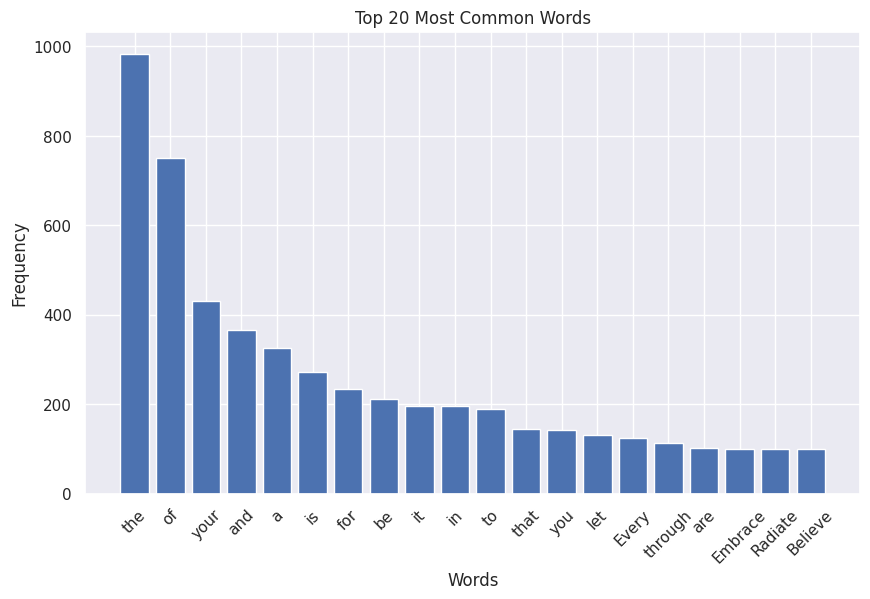

In [13]:
from collections import Counter

# Assuming 'sentences' is a list of sentences in your dataset
words = [word for sentence in eda_df["Quotes"] for word in sentence.split()]
word_freq = Counter(words)
top_20_words = dict(word_freq.most_common(20))

plt.figure(figsize=(10, 6))
plt.bar(top_20_words.keys(), top_20_words.values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Words')
plt.xticks(rotation=45)
plt.show()

In [14]:
sentence_lengths = [len(sentence.split()) for sentence in eda_df["Quotes"]]
print("Average sentence length:", sum(sentence_lengths) / len(sentence_lengths))
print("Maximum sentence length:", max(sentence_lengths))
print("Minimum sentence length:", min(sentence_lengths))

Average sentence length: 11.865
Maximum sentence length: 35
Minimum sentence length: 7


## Preprocessing

In [15]:
all_sentences = df["Quotes"].unique()

In [16]:
train, test = train_test_split(all_sentences, test_size=0.1, random_state=23)
train, validation = train_test_split(train, test_size=1/9, random_state=23)

In [17]:
all_sentences

array(["Embrace the beauty of every sunrise; it's a fresh chance to paint your world with joy.",
       'Embrace challenges; they are the stepping stones to your greatest victories.',
       'Embrace the rhythm of life and let it dance through your soul.',
       'Embrace kindness, for it has the power to change the world one heart at a time.',
       'Embrace the journey, for it leads to the destination of your dreams.',
       'Embrace your uniqueness, for it is the fingerprint of your soul on the universe.',
       'Embrace the present moment, for it is the only one that truly exists.',
       'Embrace your fears, for they hold the key to unlocking your true potential.',
       'Embrace gratitude, and watch how it multiplies the blessings in your life.',
       'Embrace the rain, for it nourishes the seeds of your future success.',
       'Embrace the whispers of your heart; they carry the wisdom of the universe.',
       'Embrace laughter, for it is the music of a joyful heart.',
 

In [18]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [19]:
import re

contractions = {
    "'s": "is",
    "'ve": "have",
    "'ll": "will"
}

def tokenize_regex(sentence, remove_spaces=True, replace_contraction=False):
    if remove_spaces:
        pattern = f'[{re.escape(string.punctuation)}]'
        split_result_spaces = re.split(f'({pattern})', sentence)
        split_result = []
        for res in split_result_spaces:
            split_result += res.split(" ")
    else:
        pattern = f'[{re.escape(string.punctuation)} ]'
        split_result = re.split(f'({pattern})', sentence)

    result = [s for s in split_result if s]

    for i in range(len(result)-1, 0, -1):
        if contractions.get(result[i-1]+result[i]):
            if replace_contraction:
                result[i-1] = contractions.get(result[i-1]+result[i])
            else:
                result[i-1] = result[i-1]+result[i]
            result.pop(i)

    return result

sentence = "Embrace the beauty of every sunrise; it's a fresh chance to paint your world with joy."
result = tokenize_regex(sentence)
print(result)

['Embrace', 'the', 'beauty', 'of', 'every', 'sunrise', ';', 'it', "'s", 'a', 'fresh', 'chance', 'to', 'paint', 'your', 'world', 'with', 'joy', '.']


In [20]:
def remove_punctuation(sentence):
    PUNC = [";", ".", ",", ":", "?", "!", "\n", "\t", "'", '"', "-"]
    output = []
    for word in sentence:
        if word not in PUNC:
            output.append(word)
    return output

# def keep_joint(sentence, joiner):
#     output = [sentence[0]]
#     for i, word in enumerate(sentence[1:]):
#         if joiner in word:
#             output.pop()
#             output.append(sentence[i-1]+word)
#             print(i, sentence)
#         else:
#             output.append(word)
#     return output

def lower_case(sentence):
    output = []
    for word in sentence:
        output.append(word.lower())
    return output

# def remove_contractions(sentence):
#     contractions = {
#         "'s": "is",
#         "'ve": "have",
#         "'ll": "will"
#     }
#     output = []
#     for word in sentence:
#         if word in contractions:
#             word = contractions[word]
#         output.append(word)
#     # print(output)
#     return output

def clean_sentences(sentences):
    for i, sentence in enumerate(sentences):
        sentences[i] = lower_case(remove_punctuation(sentence))
        # sentences[i] = lower_case(sentence)
        # sentences[i] = remove_contractions(sentence)
        # sentences[i] = keep_joint(sentences[i], "-")
    return sentences

def clean_sentences_for_input(sentences):
    for i, sentence in enumerate(sentences):
        sentences[i] = lower_case(sentence)
    #     sentences[i] = remove_contractions(sentence)
    #     # sentences[i] = keep_joint(sentences[i], "-")
    return sentences

In [21]:
tokenized_quotes = [tokenize_regex(sentence) for sentence in all_sentences]
tokenized_quotes = clean_sentences(tokenized_quotes)

In [22]:
all_words = []

for word in tokenized_quotes:
    all_words += word
    
print(f"Total word count: {len(all_words)}")

# for word in lemmatized_quotes:
#     all_words += word

all_words = list(set(all_words))

Total word count: 10926


In [23]:
for i in range(5):
    print(tokenized_quotes[i])

# for i in range(5):
#     print(lemmatized_quotes[i])
    
tokenizer = Tokenizer(split=" ", lower=True)
# tokenizer.fit_on_texts([all_words])

# with open('tokenizer.pkl', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

total_words = len(tokenizer.word_index)
print(f"Number of unique words: {total_words}")
total_words += 1

max_sequence_length = 35

['embrace', 'the', 'beauty', 'of', 'every', 'sunrise', 'it', "'s", 'a', 'fresh', 'chance', 'to', 'paint', 'your', 'world', 'with', 'joy']
['embrace', 'challenges', 'they', 'are', 'the', 'stepping', 'stones', 'to', 'your', 'greatest', 'victories']
['embrace', 'the', 'rhythm', 'of', 'life', 'and', 'let', 'it', 'dance', 'through', 'your', 'soul']
['embrace', 'kindness', 'for', 'it', 'has', 'the', 'power', 'to', 'change', 'the', 'world', 'one', 'heart', 'at', 'a', 'time']
['embrace', 'the', 'journey', 'for', 'it', 'leads', 'to', 'the', 'destination', 'of', 'your', 'dreams']
Number of unique words: 1181


In [24]:
def sentences_to_data(sentences, min_len, AorB, max_len=100, tokenize=True, verbose=0):
    # X_lemma = []
    X_word = []
    y = []

    tokenized_input = [tokenize_regex(sentence) for sentence in sentences]
    tokenized_input = clean_sentences(tokenized_input)
    
    # min_sequence_length = 4
    # max_sequence_length = 25
    if AorB:
        for sequence in tokenized_input:
            for i in range(len(sequence)):
                for j in range(i+min_len, len(sequence) if len(sequence) < i+max_len else i+max_len):
                    # X_lemma.append(" ".join(sequence[i:j]))
                    X_word.append(" ".join(sequence[i:j]))
                    y.append(sequence[j])
                    if verbose > 0:
                        if len(tokenizer.texts_to_sequences([y[-1]])[0]) != 1:
                            print(y[-1])
    else:
        for sequence in tokenized_input:
            for i in range(min_len, len(sequence) if len(sequence) < max_len else max_len):
                X_word.append(" ".join(sequence[:i]))
                y.append(sequence[i])
                if verbose > 0:
                    if len(tokenizer.texts_to_sequences([y[-1]])[0]) != 1:
                        print(y[-1])

    sentence_lengths = [len(sentence.split(" ")) for sentence in sentences]
    if verbose > 0:
        print("Average sentence length:", sum(sentence_lengths) / len(sentence_lengths))
        print("Maximum sentence length:", max(sentence_lengths))
        print("Longest sentence: ", X_word[np.argmax(sentence_lengths)])
        print("Minimum sentence length:", min(sentence_lengths))

    if tokenize:
        X_word = tokenizer.texts_to_sequences(X_word)
        X_word = pad_sequences(X_word, maxlen=max_sequence_length, padding="pre")
    else:
        X_word = clean_sentences_for_input([sentence.split(" ") for sentence in X_word])
        X_word = [" ".join(sentence) for sentence in X_word]

    y = tokenizer.texts_to_sequences(y)
    
    if verbose > 0:
        for pred, label in zip(X_word[:5], y[:5]):
            print(f"Predictor: {pred}\nLabel: {label}")
    
    y = to_categorical(y, num_classes=total_words)
    y = y.astype(float)
    y = np.array(y)

    X_word = np.array(X_word)

    if verbose > 0:
        print(X_word.shape, y.shape)

    return X_word, y

In [25]:
def fit_model(model, filepath, batch_size=32, epochs=20, callbacks=[]):
    # cp_callback = ModelCheckpoint(filepath=filepath, save_format='tf', save_weights_only=True, save_best_only=True, verbose=1, save_freq='epoch')
    
    history = model.fit(
        X_train, 
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_validation, y_validation),
        callbacks=[] + callbacks
    )
    
    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    
    print(f"Accuracy: {accuracy:.2f}")

    return history

def plot_history(fit_history, title, savefig=""):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    fig.suptitle(title)
    
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    
    left_legend = []
    for k, v in fit_history.items():
        ax[0].plot(v.history['accuracy'])
        ax[0].plot(v.history['val_accuracy'])
        left_legend += [f'{k} Train', f'{k} Validation']
    ax[0].legend(left_legend, loc='lower right')
    
    right_legend = []
    for k, v in fit_history.items():
        ax[1].plot(v.history['loss'])
        ax[1].plot(v.history['val_loss'])
        right_legend += [f'{k} Train', f'{k} Validation']
    ax[1].legend(right_legend, loc='upper right')
    
    plt.tight_layout()

    if savefig != "":
        fig.savefig(savefig, bbox_inches='tight')
    plt.show()

def joining_with_contractions(tokens):
    output = tokens[0]
    for token in tokens[1:]:
        if token not in contractions.keys():
            output += " "
        output += token
    return output

def predict_next_word(model, seed_text, next_words=1):
    for _ in range(next_words):
        seed_text = clean_sentences([tokenize_regex(seed_text)])[0]
        seed_text = " ".join(seed_text)
        
        # token_list = tokenizer.texts_to_sequences([seed_text])[0]
        # token_list = pad_sequences([token_list], maxlen=max_sequence_length, padding='pre')
        model_prediction = model.predict([seed_text], verbose=0)
        predicted_index = np.argmax(model_prediction, axis=-1)
        predicted_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                predicted_word = word
                break
        
        space = "" if predicted_word in contractions.keys() else " "
        seed_text += space + predicted_word
        seed_text = clean_sentences([tokenize_regex(seed_text)])[0]
        seed_text = joining_with_contractions(seed_text)
    return seed_text

def sample_with_temperature(probs, temperature=1.0):
    if temperature == 0:
        sampled_index = np.argmax(probs)
    else:
        # Adjust probabilities with temperature
        probs = np.power(probs, 1.0 / temperature)
        probs /= np.sum(probs)

    # print(probs)
    # Sample a word
        sampled_index = np.random.choice(len(probs), p=probs)

    # print(sampled_index)
    return sampled_index

def predict_next_word_temperature(model, seed_text, temperature, next_words=1):
    for _ in range(next_words):
        seed_text = clean_sentences([tokenize_regex(seed_text)])[0]
        seed_text = " ".join(seed_text)
        
        model_prediction = model.predict([seed_text], verbose=0)

        # print(np.array(model_prediction).shape)
        predicted_index = [sample_with_temperature(x/sum(x), temperature) for x in model_prediction][0]
        
        # predicted_index = sample_with_temperature(model_prediction, temperature)
        predicted_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                predicted_word = word
                break
        seed_text += " " + predicted_word
        seed_text = clean_sentences([tokenize_regex(seed_text)])[0]
        seed_text = joining_with_contractions(seed_text)
    return seed_text


In [26]:
# # predict_next_word_temperature

# # for seed_text in seed_texts:
# #     predicted_text = predict_next_word(simple_GRU_B, seed_text, next_words=10)
# #     print(predicted_text)
# print("Temperature: 0")

# for seed_text in seed_texts:
#     predicted_text = predict_next_word_temperature(simple_GRU_B, seed_text, 0, next_words=10)
#     print(predicted_text)

# print("Temperature: 1")

# for seed_text in seed_texts:
#     predicted_text = predict_next_word_temperature(simple_GRU_B, seed_text, 1, next_words=10)
#     print(predicted_text)

### TextVectorization

In [27]:
random.seed(42)

X_train, y_train = sentences_to_data(train, 2, True, tokenize=False, verbose=1)
X_test, y_test = sentences_to_data(test, 2, False, tokenize=False, verbose=1)
X_validation, y_validation = sentences_to_data(validation, 2, False, tokenize=False, verbose=1)

temp = list(zip(X_train, y_train))
random.shuffle(temp)
X_train, y_train = zip(*temp)
X_train = np.array(X_train)
y_train = np.array(y_train)

temp = list(zip(X_validation, y_validation))
random.shuffle(temp)
X_validation, y_validation = zip(*temp)
X_validation = np.array(X_validation)
y_validation = np.array(y_validation)

temp = list(zip(X_test, y_test))
random.shuffle(temp)
X_test, y_test = zip(*temp)
X_test = np.array(X_test)
y_test = np.array(y_test)

Average sentence length: 11.85252808988764
Maximum sentence length: 34
Longest sentence:  let your smile be the compass
Minimum sentence length: 7
Predictor: this morning
Label: [1060]
Predictor: this morning let
Label: [273]
Predictor: this morning let your
Label: [548]
Predictor: this morning let your smile
Label: [274]
Predictor: this morning let your smile be
Label: [429]
(43962,) (43962, 1182)
Average sentence length: 12.089887640449438
Maximum sentence length: 35
Longest sentence:  dance through the canvas of your
Minimum sentence length: 7
Predictor: our planet
Label: [1062]
Predictor: our planet 's
Label: [177]
Predictor: our planet 's archipelagos
Label: [314]
Predictor: our planet 's archipelagos are
Label: [429]
Predictor: our planet 's archipelagos are the
Label: [886]
(929,) (929, 1182)
Average sentence length: 12.191011235955056
Maximum sentence length: 33
Longest sentence:  this morning let your actions be a symphony of compassion love and kindness that
Minimum sentence 

In [35]:
# max_vocab_size = 10000

# vectorize_layer = TextVectorization(
#     max_tokens=max_vocab_size,
#     output_mode='int',
#     output_sequence_length=35,
#     # ngrams=5
# )

# vectorize_layer.adapt([" ".join(x) for x in clean_sentences_for_input(tokenized_quotes)])

# pickle.dump({'config': vectorize_layer.get_config(),
#              'weights': vectorize_layer.get_weights()}
#             , open("text_vectorization_layer.pkl", "wb"))

from_disk = pickle.load(open("text_vectorization_layer.pkl", "rb"))
vectorize_layer = TextVectorization.from_config(from_disk['config'])
# You have to call `adapt` with some dummy data (BUG in Keras)
vectorize_layer.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
vectorize_layer.set_weights(from_disk['weights'])

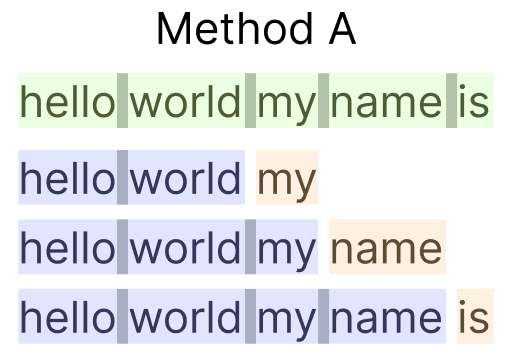

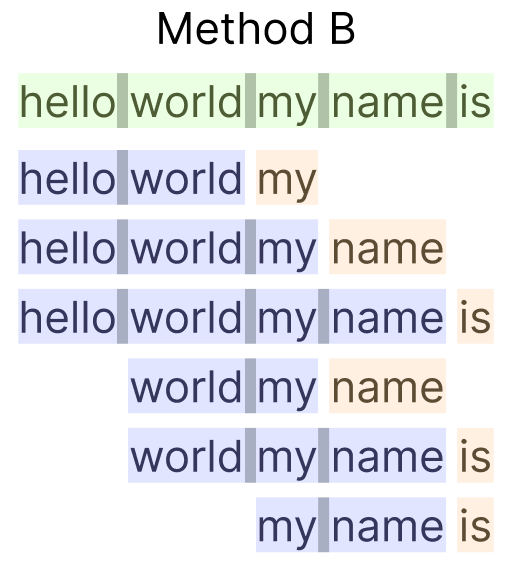

In [28]:
display(Image("images/Method A.png"))
display(Image("images/Method B.png"))

**Legend**
* Green is the original text
* Blue becomes the `X`
* Orange becomes the `y`

Method A is a more direct approach and mirrors the target task, where the predicted word is recursively added to the seed text. <br>
Method B extends this idea by creating the `X` starting from subsequent words in the original text. This creates much more data for the models to work with and I think this could help capture the word-to-word relationships better.

For both method A and B I will test and validate on method A, since that is reflective of the final word prediction task.

In [33]:
# Method A

simple_GRU_A = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(64),
    Dense(total_words, activation='softmax')
])
simple_GRU_A.compile(loss='categorical_crossentropy', optimizer=Adam(clipnorm=1), metrics=['accuracy'])

prepro_methods = {}

# min length 2
X_train, y_train = sentences_to_data(train, 2, False, tokenize=False, verbose=0)
X_test, y_test = sentences_to_data(test, 2, False, tokenize=False, verbose=0)
X_validation, y_validation = sentences_to_data(validation, 2, False, tokenize=False, verbose=0)

temp = list(zip(X_train, y_train))
random.shuffle(temp)
X_train, y_train = zip(*temp)
X_train = np.array(X_train)
y_train = np.array(y_train)

prepro_methods["A"] = fit_model(simple_GRU_A, "", batch_size=64, epochs=50)
simple_GRU_A.save("models/GRU_A.keras")

# Method B

simple_GRU_B = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(64),
    Dense(total_words, activation='softmax')
])
simple_GRU_B.compile(loss='categorical_crossentropy', optimizer=Adam(clipnorm=1), metrics=['accuracy'])

X_train, y_train = sentences_to_data(train, 2, True, tokenize=False, verbose=0)
# X_test, y_test = sentences_to_data(test, 2, True, tokenize=False, verbose=0)
# X_validation, y_validation = sentences_to_data(validation, 2, True, tokenize=False, verbose=0)

temp = list(zip(X_train, y_train))
random.shuffle(temp)
X_train, y_train = zip(*temp)
X_train = np.array(X_train)
y_train = np.array(y_train)

simple_GRU_B.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
prepro_methods["B"] = fit_model(simple_GRU_B, "", batch_size=64, epochs=50)
simple_GRU_B.save("models/GRU_B.keras")

Epoch 1/50
114/114 [==============================] - 8s 58ms/step - loss: 5.9057 - accuracy: 0.0843 - val_loss: 5.3967 - val_accuracy: 0.1366
Epoch 2/50
114/114 [==============================] - 5s 44ms/step - loss: 5.0304 - accuracy: 0.1511 - val_loss: 4.8379 - val_accuracy: 0.1900
Epoch 3/50
114/114 [==============================] - 5s 41ms/step - loss: 4.4157 - accuracy: 0.2404 - val_loss: 4.3908 - val_accuracy: 0.2946
Epoch 4/50
114/114 [==============================] - 5s 40ms/step - loss: 3.9425 - accuracy: 0.3118 - val_loss: 4.1290 - val_accuracy: 0.3458
Epoch 5/50
114/114 [==============================] - 5s 46ms/step - loss: 3.5985 - accuracy: 0.3659 - val_loss: 3.9498 - val_accuracy: 0.3682
Epoch 6/50
114/114 [==============================] - 6s 49ms/step - loss: 3.3222 - accuracy: 0.3988 - val_loss: 3.8357 - val_accuracy: 0.3842
Epoch 7/50
114/114 [==============================] - 5s 40ms/step - loss: 3.0934 - accuracy: 0.4240 - val_loss: 3.7398 - val_accuracy: 0.3895

In [ ]:
simple_GRU_B_256bs = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(64),
    Dense(total_words, activation='softmax')
])
simple_GRU_B_256bs.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
prepro_methods["B_256_bs"] = fit_model(simple_GRU_B_256bs, "", batch_size=256, epochs=50)
simple_GRU_B_256bs.save("models/GRU_B_256bs.keras")

In [28]:
simple_GRU_A = load_model('models/GRU_A.keras')
simple_GRU_B = load_model('models/GRU_B.keras')
simple_GRU_B_256bs = load_model('models/GRU_B_256bs.keras')

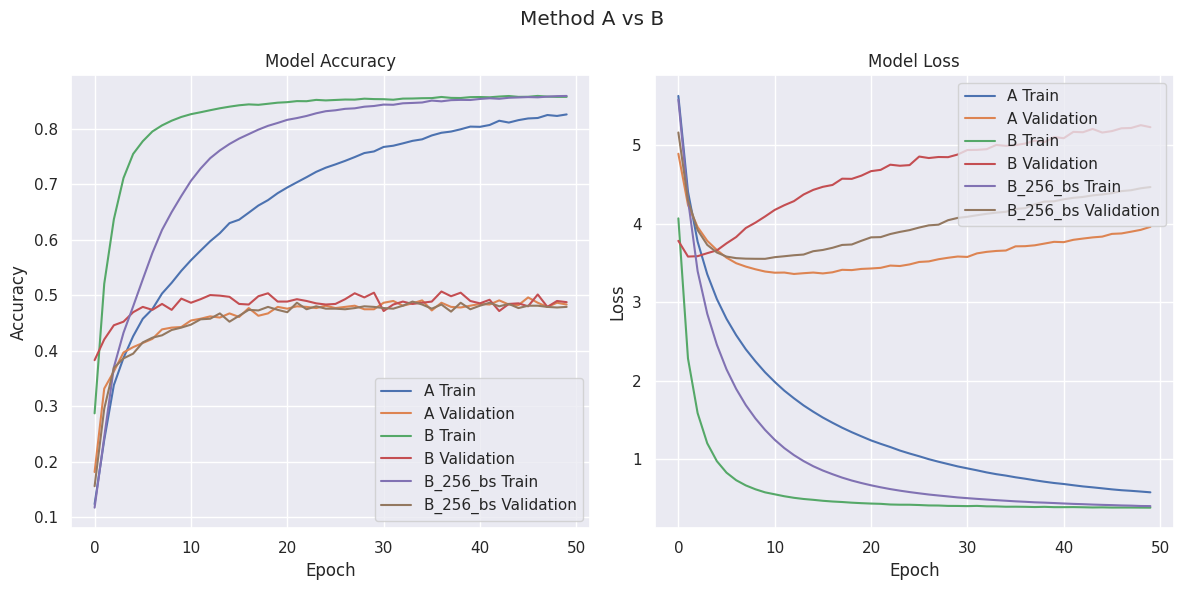

In [342]:
plot_history(prepro_methods, title="Method A vs B")

In [28]:
def eval_different_length_test(model, min_len=2, max_len=12):
    y = []
    for i in range(min_len, max_len+1):
    
        X_test, y_test = sentences_to_data(test, i, False, max_len=i+1, tokenize=False, verbose=0)
        
        accuracy = model.evaluate(X_test, y_test, verbose=0)[1]

        y.append(accuracy)
    return list(range(min_len, max_len+1)), y

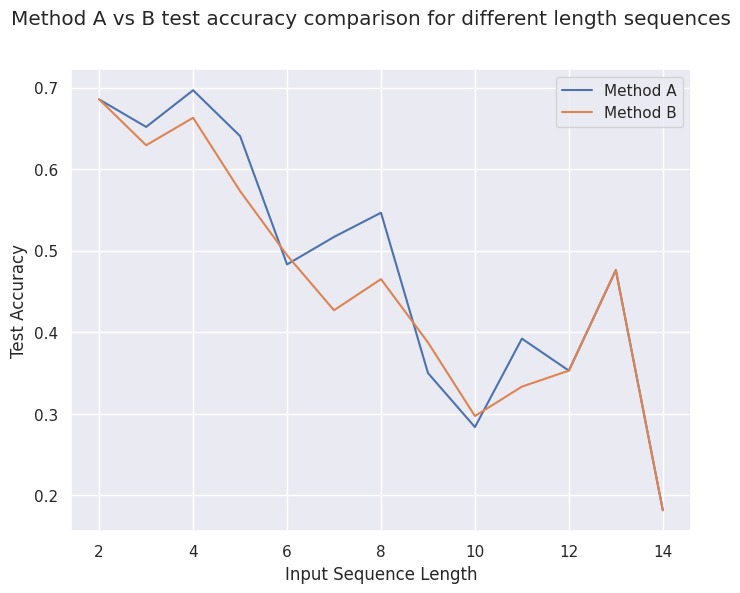

In [344]:
plt.figure(figsize=(8, 6))

x, y = eval_different_length_test(simple_GRU_A, max_len=14)
axA = sns.lineplot(x=x, y=y, label="Method A")

x, y = eval_different_length_test(simple_GRU_B_256bs, max_len=14)
axB = sns.lineplot(x=x, y=y, label="Method B")

# plt.legend(["Method A", "Method B"])
plt.legend()
plt.ylabel("Test Accuracy")
plt.xlabel("Input Sequence Length")
plt.suptitle("Method A vs B test accuracy comparison for different length sequences")

plt.show()

In [29]:
def objective_task(model, seed_texts=seed_texts, temperature=0):
    output_text = []
    for seed_text in tqdm(seed_texts):
        output_text.append(predict_next_word_temperature(model, seed_text, temperature, next_words=10))
    return output_text

In [36]:
predicted_text_A = objective_task(simple_GRU_A)
predicted_text_A

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day with a brighter future in the simple joys of life',
 'radiate some and let it be the beacon that brightens the world',
 'believe that resonates that reverberates in the heart spreading warmth and happiness',
 "life's actual purpose is a treasure trove the future of our planet's breath",
 'dance through each and every day is a gift to the world around you have',
 'let your time and energy decision decision follow follow follow follow follow follow follow follow',
 'every person is a brushstroke on the canvas of your destiny paint it',
 'our country singapore is a testament to the world creating waves of goodness laughter',
 'planet earth is contagious stones to wisdom of love and joy will follow',
 "morning and evening would make it's tapestry weaving it with threads of love and joy"]

In [37]:
predicted_text_B = objective_task(simple_GRU_B)
predicted_text_B

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day with a heart full of gratitude for the gift of',
 'radiate some for it is the heartbeat of humanity for it is',
 'believe that never stops reaching for the day ahead to protect our',
 "life's actual purpose is a chance for adventure for they are the seeds of",
 'dance through each and every step we take towards our dreams and reality in return',
 'let your time and energy be the compass that leads you to happiness and contentment',
 'every person is a treasure trove in perfect harmony creating a unique symphony',
 'our country singapore is more written with the stories of our experiences and actions',
 'planet earth is contagious written with the stories of our experiences and actions',
 'morning and evening would make it is the music that resonates in our hearts and restore']

In [347]:
predicted_text_B = objective_task(simple_GRU_B_256bs)
predicted_text_B

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day with a heart full of gratitude for it is the',
 'radiate some and let it be the beacon of your strength and',
 'believe that propels you forward is a symphony a symphony of joy',
 "life's actual purpose is a gift that keeps on giving heartbeats in arid landscapes",
 'dance through each and every day is a gift a gift from the universe a',
 'let your time and energy will follow an opportunity for growth and learning for it',
 'every person is you stronger than your fears and you will be a',
 'our country singapore is rich with the fruits of love and joy will follow',
 "planet earth is progress our planet's future are the nurseries of biodiversity",
 'morning and evening would make it knows the path to true happiness far and wide in']

* Both methods are comparable in their final results, however method B seems to improve much faster than method A.
* The comparison for test accuracy of sequences of different lengths shows that method B generally performs better.
* Both methods plateau at around 0.47 validation accuracy, while there is an inflection point where validation loss begins to increase for both.

Some sequences of words repeated in the dataset can be followed by various different words, which may be part of the reason why the probability is high for a large number of words.

## Evaluating Grammar

In [30]:
def check_grammar(text):
    return tool.check(text)

def score_grammar(texts):
    grammar_score = 0
    mistakes = []
    for text in texts:
        mistakes.append(check_grammar(text))
    for mistakeses in mistakes:
        for mistake in mistakeses:
            if mistake.ruleId != "MORFOLOGIK_RULE_EN_US" and mistake.ruleId != "UPPERCASE_SENTENCE_START":
                grammar_score += 1
    grammar_score /= len(texts)
    return grammar_score, mistakes

In [349]:
print(f"Method A average number of mistakes : {score_grammar(predicted_text_A)[0]}")
print(f"Method B average number of mistakes : {score_grammar(predicted_text_B)[0]}")

Method A average number of mistakes : 0.1
Method B average number of mistakes : 0.3


In [350]:
print(f"Average number of mistakes in the given dataset: {score_grammar(all_sentences)[0]}")

Average number of mistakes in the given dataset: 0.0056179775280898875


In [351]:
test[:10]

array(["Our planet's archipelagos are the jewels set in the crown of the sea.",
       'Believe in yourself, and you will be a beacon of light for others.',
       'Believe in yourself, and you will make a difference.',
       'Every sunset is a reminder of the beauty in letting go.',
       'Every act of empathy is a bridge that connects souls.',
       'Dance through the canvas of your destiny, painting it with intention and love.',
       'Radiate determination, and let it be the fuel that powers your journey.',
       'With the rising sun, let gratitude fill every corner of your heart this morning.',
       "From Singapore Zoo's wonders to River Safari's adventures, Singapore's wildlife is a treasure.",
       'Every act of conservation is a vote for the future of our planet.'],
      dtype=object)

In [352]:
test_seed_texts = []
for sentence in test:
    test_seed_texts.append(" ".join(tokenize_regex(sentence)[:2]))
test_seed_texts = list(set(test_seed_texts))

In [328]:
predicted_test_text_A = objective_task(simple_GRU_A, seed_texts=test_seed_texts)
predicted_test_text_A[:10]

  0%|          | 0/37 [00:00<?, ?it/s]

['every challenge overcome is a testament to the beauty of the human',
 "life's journey is a classroom where we learn to love ourselves",
 'radiate strength and let it be the foundation of your strength and',
 'radiate determination and let it be the foundation of your strength and',
 'in the heart of this lion city hope lights the way for',
 "singapore's skyline embodies the spirit of progress and innovation and change",
 "from singapore's beauty is boundless purpose resilience defines the tranquility of",
 "our planet's caves are the silent galleries of nature's artistry",
 'every friendship formed is a gem in the treasury of memories a',
 "every drop is a beam of light in someone's day leaving"]

In [353]:
grammar_score, mistakes = score_grammar(predicted_test_text_A)
print(grammar_score)
all_mistakes = []
for mistake in mistakes:
    all_mistakes += mistake

0.05405405405405406


In [354]:
[(x.message) for x in all_mistakes]

['This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'Possible spelling mistake found.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'Possible spelling mistake found.',
 'Possible spelling mistake found.',
 'This sentence does not start with an uppercase letter.',
 'This phrase is duplicated. You should probably use “an investment” only once.',
 'This sentence does not start with an u

In [355]:
predicted_test_text_B = objective_task(simple_GRU_B_256bs, seed_texts=test_seed_texts)
predicted_test_text_B[:10]

  0%|          | 0/37 [00:00<?, ?it/s]

['every challenge faced is an opportunity for growth and learning for it',
 "life's garden flourishes when tended with patience and compassion and understanding",
 'radiate strength and let it be the beacon of your strength and',
 'radiate determination and let it be the sunrise in your darkest nights',
 'in the heart of this lion city dreams find their wings and',
 "singapore's nature is a sanctuary of serenity within you have into",
 "from singapore's nature is a sanctuary of serenity within you have",
 "our planet's future are the thresholds of life's transition from",
 'every friendship formed is a gem a gem in the treasury the',
 'every drop is contagious is a sanctuary of serenity within you have']

In [356]:
grammar_score, mistakes = score_grammar(predicted_test_text_B)
print(grammar_score)
all_mistakes = []
for mistake in mistakes:
    all_mistakes += mistake

0.08108108108108109


In [357]:
[x.message for x in all_mistakes]

['This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'Possible spelling mistake found.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This phrase is duplicated. You should probably use “a gem” only once.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'Possible spelling mistake found.',
 'Possible spelling mistake found.',
 'Possible spelling mistake found.',
 'This sentence does not start with an uppercase letter.',
 'This sent

Method A and B produce comparable sentences

## Other Metrics
* BLEU

In [31]:
def score_bleu(sentences, verbose=0):
    total_bleu_score = 0
    for sentence in sentences:
        temp = sentence_bleu(clean_sentences_for_input(clean_sentences([tokenize_regex(x) for x in all_sentences])), clean_sentences_for_input(clean_sentences([tokenize_regex(sentence)]))[0], auto_reweigh=True)
        total_bleu_score += temp
        if verbose > 0:
            print(f"{sentence}, {temp}")
    return total_bleu_score/len(sentences)

In [359]:
score_bleu(predicted_text_A)

0.7084270528669403

In [360]:
score_bleu(predicted_text_B)

0.7128875652171699

In [361]:
score_bleu(predicted_test_text_A)

0.9456627085507899

In [362]:
score_bleu(predicted_test_text_B)

0.9423714318287745

In [259]:
score_bleu(objective_task(simple_GRU_B))

  0%|          | 0/10 [00:00<?, ?it/s]

0.65636736274409

In [260]:
score_bleu(objective_task(simple_GRU_B, temperature=0.2))

  0%|          | 0/10 [00:00<?, ?it/s]

0.6708538034636378

In [261]:
score_bleu(objective_task(simple_GRU_B, temperature=0.3))

  0%|          | 0/10 [00:00<?, ?it/s]

0.6855230072413249

In [262]:
score_bleu(objective_task(simple_GRU_B, temperature=0.4))

  0%|          | 0/10 [00:00<?, ?it/s]

0.6751672192304635

In [263]:
score_bleu(objective_task(simple_GRU_B, temperature=0.5))

  0%|          | 0/10 [00:00<?, ?it/s]

0.6594354304425787

In [264]:
score_bleu(objective_task(simple_GRU_B, temperature=1))

  0%|          | 0/10 [00:00<?, ?it/s]

0.6096224587760909

In [33]:
def calculate_scoring_metrics(model):
    test_seed_texts = []
    for sentence in test:
        test_seed_texts.append(" ".join(tokenize_regex(sentence)[:2]))
    for sentence in test:
        test_seed_texts.append(" ".join(tokenize_regex(sentence)[:3]))
    for sentence in test:
        test_seed_texts.append(" ".join(tokenize_regex(sentence)[:4]))
    test_seed_texts = list(set(test_seed_texts))
    
    scores = {}
    predicted_test_texts = objective_task(model, seed_texts=test_seed_texts)
    # P, R, F1 = score(predicted_test_texts, list(test), lang="en", verbose=True)

    # scores["Precision"] = P.mean().item()
    # scores["Recall"] = R.mean().item()
    # scores["F1"] = F1.mean().item()

    grammar_score, mistakes = score_grammar(predicted_test_texts)
    all_mistakes = []
    for mistake in mistakes:
        all_mistakes += mistake
    
    scores["mean_mistakes"] = grammar_score
    scores["bleu"] = score_bleu(predicted_test_texts)
    # scores["mistakes"] = all_mistakes
    return scores, predicted_test_texts

X_train, y_train = sentences_to_data(train, 2, False, tokenize=False, verbose=0)

I will use Method A when evaluating the different model architectures since it has roughly equal results with a smaller training set and therefore shorter train time.

## SimpleRNN (Recurrent Neural Network) vs GRU (Gated Recurrent Unit) vs LSTM (Long Short-Term Memory)

In [39]:
all_RNN_scores = {}
basic_RNNs = {}

early_stopping = EarlyStopping(
    monitor="loss",
    start_from_epoch=0,
    patience=1,
    min_delta=0.01,
    mode="min",
    restore_best_weights=True
)

In [40]:
simple_RNN = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    SimpleRNN(64),
    Dense(total_words, activation='softmax')
])
simple_RNN.compile(loss='categorical_crossentropy', optimizer=Adam(clipnorm=1), metrics=['accuracy'])

basic_RNNs["SimpleRNN"] = fit_model(simple_RNN, "", batch_size=64, epochs=50, callbacks=[])
simple_RNN.save("models/SimpleRNN.keras")

Epoch 1/50
114/114 [==============================] - 10s 74ms/step - loss: 5.8257 - accuracy: 0.1010 - val_loss: 5.3113 - val_accuracy: 0.1195
Epoch 2/50
114/114 [==============================] - 7s 63ms/step - loss: 4.9747 - accuracy: 0.1479 - val_loss: 4.7918 - val_accuracy: 0.1825
Epoch 3/50
114/114 [==============================] - 7s 60ms/step - loss: 4.4045 - accuracy: 0.2455 - val_loss: 4.3607 - val_accuracy: 0.3020
Epoch 4/50
114/114 [==============================] - 7s 58ms/step - loss: 3.9262 - accuracy: 0.3194 - val_loss: 4.0853 - val_accuracy: 0.3554
Epoch 5/50
114/114 [==============================] - 7s 58ms/step - loss: 3.5674 - accuracy: 0.3701 - val_loss: 3.9082 - val_accuracy: 0.3735
Epoch 6/50
114/114 [==============================] - 7s 59ms/step - loss: 3.2823 - accuracy: 0.4056 - val_loss: 3.7810 - val_accuracy: 0.3895
Epoch 7/50
114/114 [==============================] - 6s 54ms/step - loss: 3.0415 - accuracy: 0.4349 - val_loss: 3.6860 - val_accuracy: 0.404

In [41]:
simple_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 35)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 35, 768)           907776    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                53312     
                                                                 
 dense (Dense)               (None, 1182)              76830     
                                                                 
Total params: 1037918 (3.96 MB)
Trainable params: 1037918 (3.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [91]:
display(objective_task(simple_RNN))

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day with a is a symphony of joy in the heart',
 'radiate some for it is the key to unlocking your true potential',
 'believe that yourself for you are capable of conquering any obstacle that',
 "life's actual purpose is a testament to the beauty of our uniqueness for it",
 'dance through each and every step we take towards our dreams and actions spirit of',
 "let your time and energy of endurance and adaptation vision honed tomorrow's path is",
 'every person is a trail of smiles and warmth and wisdom of nature',
 'our country singapore is skyline tells a story of progress and vision the lifeblood',
 'planet earth is of existence wind you have into the beauty of resilience',
 "morning and evening would make it knows no bounds reserve's tranquility to southern ridges breathtaking"]

In [42]:
simple_GRU = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(64),
    Dense(total_words, activation='softmax')
])
simple_GRU.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

basic_RNNs["GRU"] = fit_model(simple_GRU, "", batch_size=64, epochs=50, callbacks=[])
simple_GRU.save("models/GRU.keras")

Epoch 1/50
114/114 [==============================] - 9s 62ms/step - loss: 5.9404 - accuracy: 0.1049 - val_loss: 5.3782 - val_accuracy: 0.0790
Epoch 2/50
114/114 [==============================] - 5s 42ms/step - loss: 5.0115 - accuracy: 0.1446 - val_loss: 4.8194 - val_accuracy: 0.1878
Epoch 3/50
114/114 [==============================] - 4s 39ms/step - loss: 4.4018 - accuracy: 0.2368 - val_loss: 4.3605 - val_accuracy: 0.3116
Epoch 4/50
114/114 [==============================] - 4s 38ms/step - loss: 3.9189 - accuracy: 0.3162 - val_loss: 4.0895 - val_accuracy: 0.3372
Epoch 5/50
114/114 [==============================] - 4s 38ms/step - loss: 3.5656 - accuracy: 0.3625 - val_loss: 3.9190 - val_accuracy: 0.3703
Epoch 6/50
114/114 [==============================] - 4s 39ms/step - loss: 3.2890 - accuracy: 0.3985 - val_loss: 3.7919 - val_accuracy: 0.3725
Epoch 7/50
114/114 [==============================] - 4s 39ms/step - loss: 3.0615 - accuracy: 0.4240 - val_loss: 3.6979 - val_accuracy: 0.3895

In [43]:
simple_GRU.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 35)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 35, 768)           907776    
                                                                 
 gru (GRU)                   (None, 64)                160128    
                                                                 
 dense_1 (Dense)             (None, 1182)              76830     
                                                                 
Total params: 1144734 (4.37 MB)
Trainable params: 1144734 (4.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [94]:
display(objective_task(simple_GRU))

  0%|          | 0/10 [00:00<?, ?it/s]

["embrace each day's garden flourishes when tended with acts of kindness and",
 'radiate some and let it be the wind in your sails on',
 'believe that truly exists exists exists exists exists exists exists exists exists',
 "life's actual purpose is a promise to protect the treasures of our planet's",
 "dance through each and every day is a beacon of hope for our planet's",
 'let your time and energy flight flight flight flight forward flight flight flight flight flight',
 'every person is a testament to the beauty of our uniqueness for our',
 'our country singapore is a gem in the treasury of memories and farewells morning',
 "planet earth is's a leap of faith is a step towards witnessing",
 "morning and evening would make it's abundance for it is woven with purpose and determination"]

In [44]:
simple_LSTM = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    LSTM(64),
    Dense(total_words, activation='softmax')
])
simple_LSTM.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

basic_RNNs["LSTM"] = fit_model(simple_LSTM, "", batch_size=64, epochs=50, callbacks=[])
simple_LSTM.save("models/LSTM.keras")

Epoch 1/50
114/114 [==============================] - 8s 61ms/step - loss: 5.9164 - accuracy: 0.0859 - val_loss: 5.4005 - val_accuracy: 0.0779
Epoch 2/50
114/114 [==============================] - 5s 43ms/step - loss: 5.1543 - accuracy: 0.0841 - val_loss: 5.1728 - val_accuracy: 0.1099
Epoch 3/50
114/114 [==============================] - 5s 41ms/step - loss: 4.9050 - accuracy: 0.1298 - val_loss: 4.9768 - val_accuracy: 0.1441
Epoch 4/50
114/114 [==============================] - 4s 39ms/step - loss: 4.6167 - accuracy: 0.1842 - val_loss: 4.6999 - val_accuracy: 0.2380
Epoch 5/50
114/114 [==============================] - 4s 38ms/step - loss: 4.2793 - accuracy: 0.2613 - val_loss: 4.4156 - val_accuracy: 0.3127
Epoch 6/50
114/114 [==============================] - 4s 39ms/step - loss: 3.9782 - accuracy: 0.3192 - val_loss: 4.2184 - val_accuracy: 0.3533
Epoch 7/50
114/114 [==============================] - 5s 40ms/step - loss: 3.7287 - accuracy: 0.3548 - val_loss: 4.0723 - val_accuracy: 0.3629

In [45]:
simple_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 35)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 35, 768)           907776    
                                                                 
 lstm (LSTM)                 (None, 64)                213248    
                                                                 
 dense_2 (Dense)             (None, 1182)              76830     
                                                                 
Total params: 1197854 (4.57 MB)
Trainable params: 1197854 (4.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [97]:
display(objective_task(simple_LSTM))

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day is a gift a reminder of the soul of the',
 'radiate some and let it be the compass that guides your way',
 'believe that you are yourself for you have the power to change',
 "life's actual purpose is reflected in the tranquility of the heart and growth and",
 'dance through each and every step a step towards the tranquility of the heart of',
 'let your time and energy be the wind in the beauty in transitions and let',
 "every person is a promise to face of our planet's future success",
 'our country singapore is a testament to endurance and possibility for your dreams and',
 "planet earth is a testament to our commitment to our planet's future",
 "morning and evening would make it's warmth and joy in the power of every moment"]

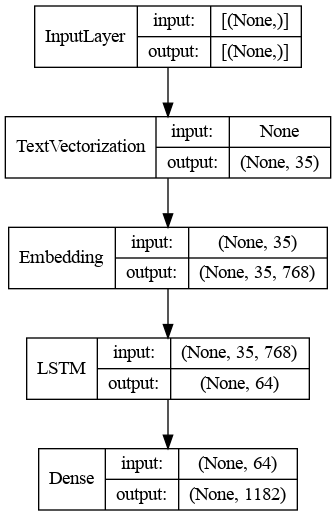

In [46]:
plot_model(simple_LSTM, show_shapes=True, show_layer_names=False)

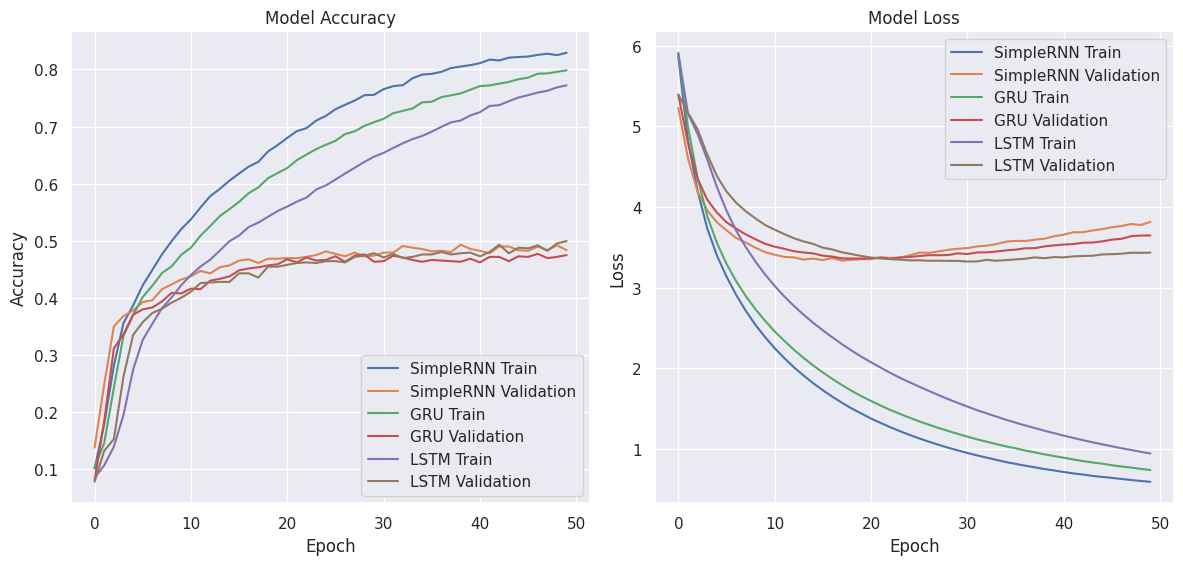

In [98]:
plot_history(basic_RNNs, "")

* SimpleRNN, LSTM, and GRU can all achieve roughly the same accuracy.
* All of the models start overfitting quickly.
* GRU is the fastest to train followed by LSTM then SimpleRNN in terms of time
* All of the models have an increasing loss over time.
* Both LSTM and GRU could work for this application so I may explore both.

## Model Improvement
* Increasing model complexity (Number of units, number of layers)
* Bidirectional
* n-gram Text Vectorization
* Self-Attention Mechanism
    * Sequences from LSTM with the resultant hidden state of the LSTM
* Dropout after Embedding
    * this essentially creates "blanks" in the input which could help when dealing with words that are not present in the reference dataset like "some" which is in the seed text

In [32]:
def simple_LSTM_seq(lstm_units):
    return Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    LSTM(lstm_units),
    Dense(total_words, activation='softmax')
])

In [36]:
more_LSTMs = {}

simple_LSTM_128 = simple_LSTM_seq(128)
simple_LSTM_128.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

more_LSTMs["LSTM_128"] = fit_model(simple_LSTM_128, "", batch_size=64, epochs=50, callbacks=[])
simple_LSTM_128.save("models/LSTM_128.keras")

simple_LSTM_128_2 = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dense(total_words, activation='softmax')
])
simple_LSTM_128_2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

more_LSTMs["LSTM_128_2"] = fit_model(simple_LSTM_128_2, "", batch_size=64, epochs=50, callbacks=[])
simple_LSTM_128_2.save("models/LSTM_128_2.keras")

Epoch 1/50
114/114 [==============================] - 9s 47ms/step - loss: 5.7975 - accuracy: 0.1041 - val_loss: 5.2107 - val_accuracy: 0.1078
Epoch 2/50
114/114 [==============================] - 2s 17ms/step - loss: 4.8292 - accuracy: 0.1670 - val_loss: 4.6985 - val_accuracy: 0.2359
Epoch 3/50
114/114 [==============================] - 2s 14ms/step - loss: 4.2394 - accuracy: 0.2779 - val_loss: 4.2622 - val_accuracy: 0.3340
Epoch 4/50
114/114 [==============================] - 2s 13ms/step - loss: 3.7634 - accuracy: 0.3505 - val_loss: 4.0079 - val_accuracy: 0.3874
Epoch 5/50
114/114 [==============================] - 1s 13ms/step - loss: 3.4203 - accuracy: 0.3901 - val_loss: 3.8245 - val_accuracy: 0.4045
Epoch 6/50
114/114 [==============================] - 1s 12ms/step - loss: 3.1484 - accuracy: 0.4166 - val_loss: 3.7219 - val_accuracy: 0.4141
Epoch 7/50
114/114 [==============================] - 1s 13ms/step - loss: 2.9174 - accuracy: 0.4434 - val_loss: 3.6089 - val_accuracy: 0.4312

In [37]:
objective_task(simple_LSTM_128)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day is a fresh start for new beginnings and fresh start',
 'radiate some and let it be the foundation of your strength and',
 'believe that you encounter carries a story of your journey a tale',
 "life's actual purpose is the harmonious blend of our dreams and reality and deeds",
 'dance through each and every day is a pledge to tread lightly on our planet',
 'let your time and energy be the cradle of biodiversity and joy that others find',
 'every person is a canvas for new beginnings and you are not alone',
 "our country singapore is the cradle from which life springs forth life's adaptability",
 'planet earth is the nurseries of biodiversity and life for many coastal species',
 "morning and evening would make it with the beauty in our heart's beauty is more"]

In [38]:
objective_task(simple_LSTM_128_2)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day for it is a canvas of your being beginnings and',
 'radiate some and let it be the bridge that mends hearts that',
 'believe that yourself and you are a future in the darkness that',
 "life's actual purpose is a fresh start and new beginnings take take moments towards",
 'dance through each and every heart they hold the beauty in every day and journey',
 'let your time and energy be the sword that cuts through fear and joy in',
 'every person is a tapestry it with threads of love and hope and',
 "our country singapore is a tapestry woven with threads of life's tenacity are",
 'planet earth is a tapestry of grass and vibrant step and joy in',
 "morning and evening would make it with your heart reminding you of your day's journey"]

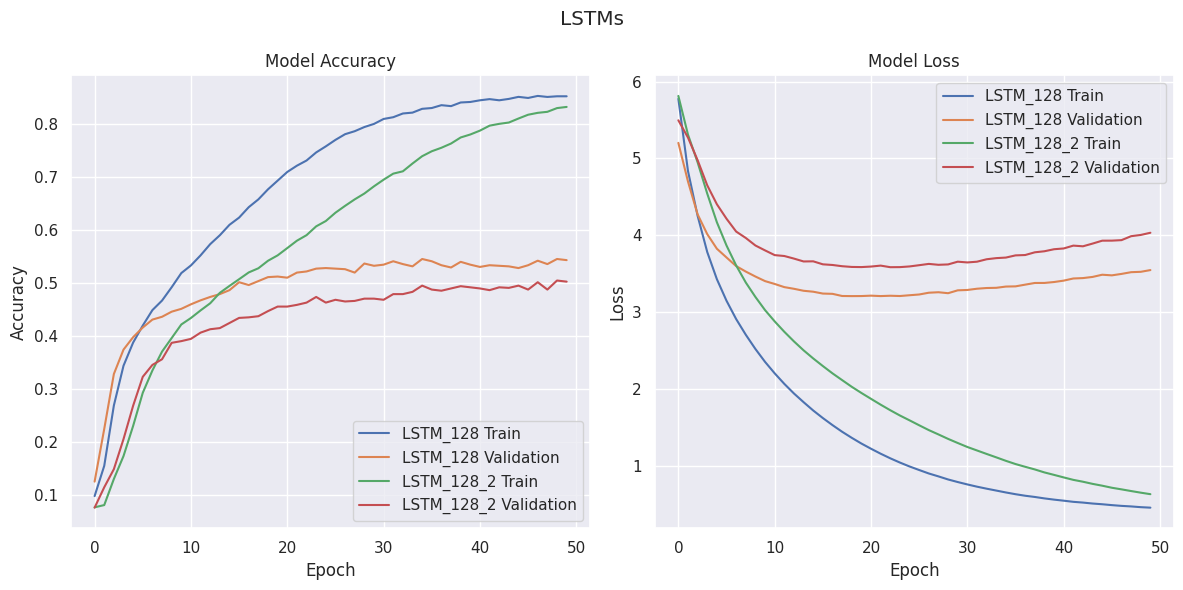

In [101]:
plot_history(more_LSTMs, "LSTMs")

No benefit to using 2 layers since the data is already not very complex.

In [39]:
more_LSTMs = {}

simple_LSTM_256 = simple_LSTM_seq(256)
simple_LSTM_256.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

more_LSTMs["LSTM_256"] = fit_model(simple_LSTM_256, "", batch_size=64, epochs=50, callbacks=[])
simple_LSTM_256.save("models/LSTM_256.keras")

simple_LSTM_512 = simple_LSTM_seq(512)
simple_LSTM_512.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

more_LSTMs["LSTM_512"] = fit_model(simple_LSTM_512, "", batch_size=64, epochs=50, callbacks=[])
simple_LSTM_512.save("models/LSTM_512.keras")

simple_LSTM_1024 = simple_LSTM_seq(1024)
simple_LSTM_1024.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

more_LSTMs["LSTM_1024"] = fit_model(simple_LSTM_1024, "", batch_size=64, epochs=50, callbacks=[])
simple_LSTM_1024.save("models/LSTM_1024.keras")

Epoch 1/50
114/114 [==============================] - 5s 34ms/step - loss: 5.6400 - accuracy: 0.1058 - val_loss: 5.0223 - val_accuracy: 0.1451
Epoch 2/50
114/114 [==============================] - 2s 16ms/step - loss: 4.4648 - accuracy: 0.2433 - val_loss: 4.2268 - val_accuracy: 0.3362
Epoch 3/50
114/114 [==============================] - 2s 14ms/step - loss: 3.6946 - accuracy: 0.3606 - val_loss: 3.8468 - val_accuracy: 0.4034
Epoch 4/50
114/114 [==============================] - 1s 13ms/step - loss: 3.1821 - accuracy: 0.4163 - val_loss: 3.6533 - val_accuracy: 0.4280
Epoch 5/50
114/114 [==============================] - 1s 12ms/step - loss: 2.7937 - accuracy: 0.4567 - val_loss: 3.5035 - val_accuracy: 0.4450
Epoch 6/50
114/114 [==============================] - 1s 13ms/step - loss: 2.4735 - accuracy: 0.4971 - val_loss: 3.4039 - val_accuracy: 0.4610
Epoch 7/50
114/114 [==============================] - 2s 14ms/step - loss: 2.1990 - accuracy: 0.5342 - val_loss: 3.3111 - val_accuracy: 0.4728

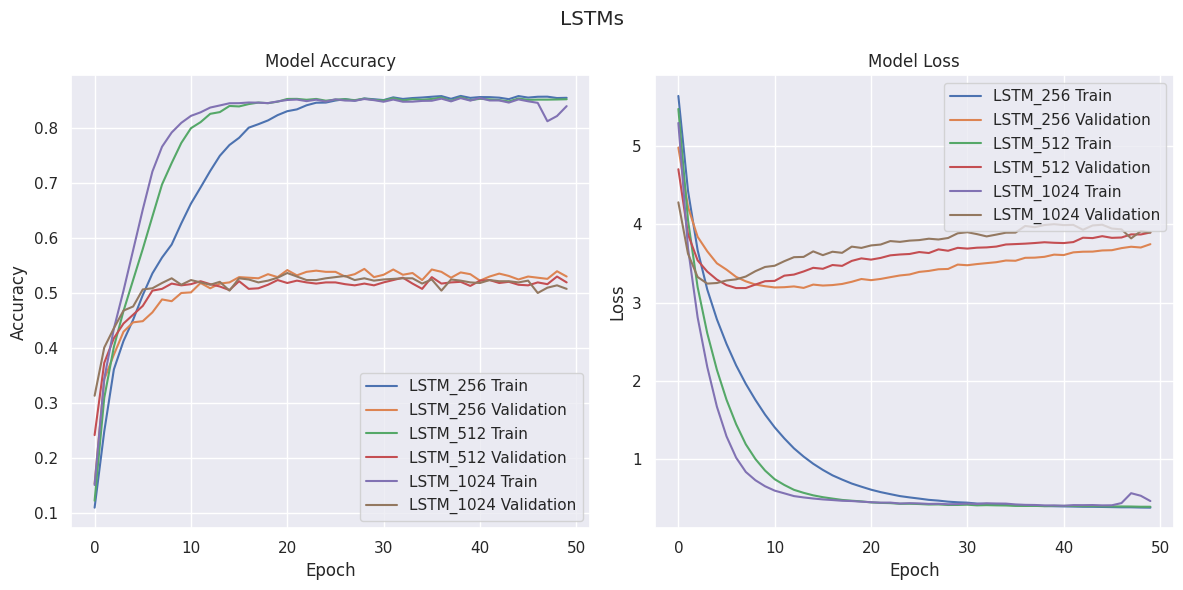

In [103]:
plot_history(more_LSTMs, "LSTMs")

In [60]:
objective_task(simple_LSTM_256)

  0%|          | 0/10 [00:00<?, ?it/s]

["embrace each day for it is the heartbeat of our planet's future",
 'radiate some and let it be the foundation of your strength and',
 'believe that you are a work of art in progress and innovation',
 "life's actual purpose is the language of the soul and soul and our heart",
 "dance through each and every sunrise it's tapestry for it is a gift that",
 'let your time and energy be your wings and joy in the melody of a',
 'every person is a reminder of the hope and potential within our planet',
 "our country singapore is a tapestry woven with threads of life's vitality singapore",
 'planet earth is the cradle of biodiversity and resilience and resilience of endurance',
 'morning and evening would make it with the melody of hope and possibility it knows no']

In [61]:
objective_task(simple_LSTM_512)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day is a fresh canvas paint it with vibrant strokes of',
 "radiate some and let it be the melody of your life's",
 'believe that you are the architect of your destiny of self aspirations',
 "life's actual purpose is a tapestry woven with threads of love and hope and",
 'dance through each and every day brings a new day full of compassion for the',
 'let your time and energy be the spark that ignites positivity and light in the',
 'every person is a setup for a glorious comeback of your future success',
 'our country singapore is the sword that cuts through fear hearts and waters across',
 'planet earth is the tapestry of every tales and resilience of progress and',
 'morning and evening would make it with the melody of your heart and soul and you']

In [62]:
objective_task(simple_LSTM_1024)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day is a fresh canvas paint it with vibrant strokes of',
 'radiate some and let it be the bridge that mends hearts of',
 'believe that you are a world of time possibilities and richness that',
 "life's actual purpose is a tapestry woven with threads of love and laughter and",
 'dance through each and every how it with love and courage your world with the',
 'let your time and energy be the bridge that fosters understanding and light that shine',
 'every person is a gesture of hope for the future of our planet',
 'our country singapore is a canvas painted with the brushstrokes of survival memories a',
 'planet earth is a canvas for it with vibrant experiences and aspirations and',
 'morning and evening would make it with the world of your heart and soul and encounter']

In [63]:
ngram_RNNs = {}
max_vocab_size = 50000

vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=200,
    ngrams=1
)

vectorize_layer.adapt([" ".join(x) for x in clean_sentences_for_input(tokenized_quotes)])

simple_LSTM_256_1gram = simple_LSTM_seq(256)
simple_LSTM_256_1gram.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

ngram_RNNs["1-gram"] = fit_model(simple_LSTM_256_1gram, "", batch_size=64, epochs=50, callbacks=[])
simple_LSTM_256_1gram.save("models/LSTM_256_1gram.keras")

vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=200,
    ngrams=2
)

vectorize_layer.adapt([" ".join(x) for x in clean_sentences_for_input(tokenized_quotes)])

simple_LSTM_256_2gram = simple_LSTM_seq(256)
simple_LSTM_256_2gram.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

ngram_RNNs["2-gram"] = fit_model(simple_LSTM_256_2gram, "", batch_size=64, epochs=50, callbacks=[])
simple_LSTM_256_2gram.save("models/LSTM_256_2gram.keras")

vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=200,
    ngrams=3
)

vectorize_layer.adapt([" ".join(x) for x in clean_sentences_for_input(tokenized_quotes)])

simple_LSTM_256_3gram = simple_LSTM_seq(256)
simple_LSTM_256_3gram.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

ngram_RNNs["3-gram"] = fit_model(simple_LSTM_256_3gram, "", batch_size=64, epochs=50, callbacks=[])
simple_LSTM_256_3gram.save("models/LSTM_256_3gram.keras")

vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=200,
    ngrams=4
)

vectorize_layer.adapt([" ".join(x) for x in clean_sentences_for_input(tokenized_quotes)])

simple_LSTM_256_4gram = simple_LSTM_seq(256)
simple_LSTM_256_4gram.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

ngram_RNNs["4-gram"] = fit_model(simple_LSTM_256_4gram, "", batch_size=64, epochs=50, callbacks=[])
simple_LSTM_256_4gram.save("models/LSTM_256_4gram.keras")

Epoch 1/50
114/114 [==============================] - 7s 43ms/step - loss: 5.6043 - accuracy: 0.1147 - val_loss: 4.9381 - val_accuracy: 0.1505
Epoch 2/50
114/114 [==============================] - 2s 17ms/step - loss: 4.3963 - accuracy: 0.2549 - val_loss: 4.1832 - val_accuracy: 0.3490
Epoch 3/50
114/114 [==============================] - 2s 16ms/step - loss: 3.6336 - accuracy: 0.3677 - val_loss: 3.8068 - val_accuracy: 0.3991
Epoch 4/50
114/114 [==============================] - 2s 15ms/step - loss: 3.1383 - accuracy: 0.4188 - val_loss: 3.6230 - val_accuracy: 0.4312
Epoch 5/50
114/114 [==============================] - 2s 14ms/step - loss: 2.7457 - accuracy: 0.4615 - val_loss: 3.4723 - val_accuracy: 0.4546
Epoch 6/50
114/114 [==============================] - 2s 15ms/step - loss: 2.4107 - accuracy: 0.5004 - val_loss: 3.3717 - val_accuracy: 0.4440
Epoch 7/50
114/114 [==============================] - 2s 16ms/step - loss: 2.1226 - accuracy: 0.5416 - val_loss: 3.2764 - val_accuracy: 0.4685

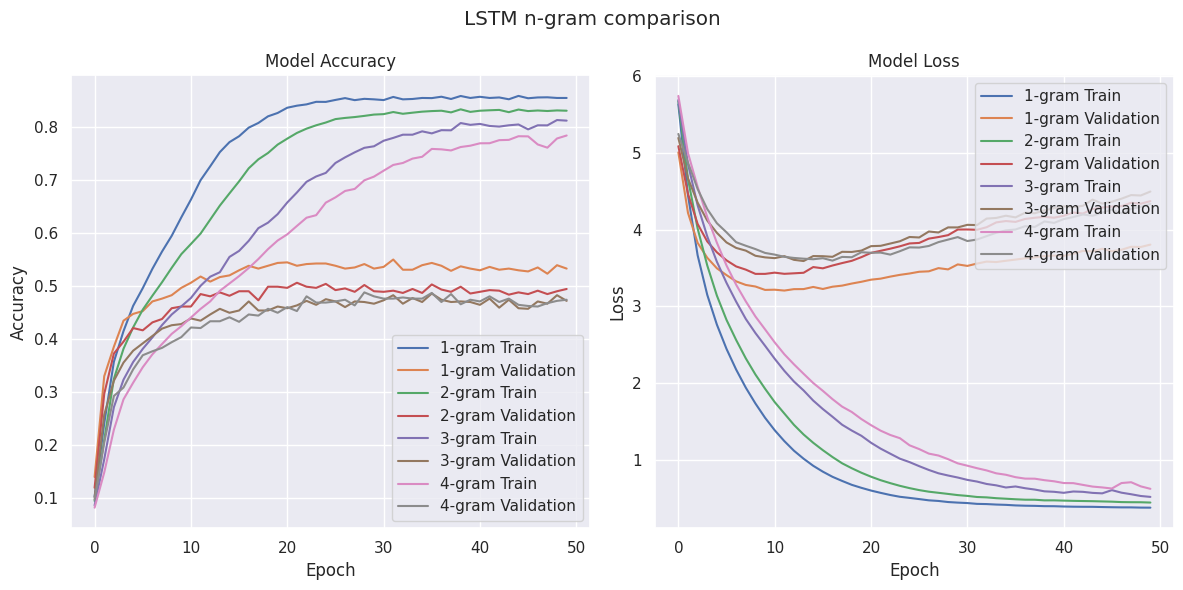

In [108]:
plot_history(ngram_RNNs, "LSTM n-gram comparison")

In [64]:
objective_task(simple_LSTM_256_1gram)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day for it is the only one that truly exists exists',
 "radiate some and let it be the fortress of your spirit's",
 'believe that you are a testament to your indomitable spirit a living',
 "life's actual purpose is a testament to the beauty of our uniqueness and resilience",
 'dance through each and every moment of gratitude for it is the key to a',
 "let your time and energy be the lighthouse in the turbulent seas of life's",
 'every person is a setup for a glorious comeback of kindness and potential',
 "our country singapore is the wide open canvases of nature's palette and determination",
 "planet earth is the silent galleries of nature's artistry is a marvel",
 "morning and evening would make it with the day well lived life's precious gifts and"]

In [65]:
objective_task(simple_LSTM_256_2gram)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day is a gift a reminder of the marvel of existence',
 'radiate some and find peace in embracing what is into blessings life',
 'believe that joyous joyous persevere persevere persevere persevere persevere persevere persevere persevere',
 "life's actual purpose is by the light of our inner wisdom and kindness and",
 'dance through each and every is a promise of warmth and life for our planet',
 'let your time and energy be the canvas of your true self shine your dreams',
 'every person is encounter a can into into your that of be planet',
 'our country singapore is the heartbeat of transformation and and a inner of a',
 'planet earth is a testament to the beauty of every strength and resilience',
 'morning and evening would make it the of heart planet purpose resilience way way the and']

In [66]:
objective_task(simple_LSTM_256_3gram)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day is a chance to future future the of future your',
 'radiate some and find peace in embracing what is a a of',
 'believe that shared has the power to shape your reality and influence',
 "life's actual purpose is by rainbows of hope and hope dreams for a dreams",
 'dance through each and every is a gift to the universe life of our planet',
 "let your time and energy'll than you you in in blessings life's forth",
 'every person is your in the blessings of life of of the of',
 "our country singapore is a of on the a of our planet's pollinators",
 'planet earth is a reminder of the preciousness of life of our planet',
 'morning and evening would make it brighter brighter future of soul the of the of potential']

In [67]:
objective_task(simple_LSTM_256_4gram)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day is a promise of new new beginnings day new day',
 'radiate some and let it be the foundation of your legacy of',
 'believe that heart of we can in the of possibility in future',
 "life's actual purpose is by the we offer with others others the others for",
 'dance through each and every let it lungs spirit to creating life of of goodness',
 "let your time and energy for it is the source of your life song's",
 'every person is a setup for a glorious comeback comeback comeback heart the',
 "our country singapore is the of a's and dreams and resilience of and",
 "planet earth is a testament to the beauty of our uniqueness's's",
 'morning and evening would make it creating of gratitude bitterness gratitude unique symphony joy joy joy']

In [113]:
vectorize_layer("let your time and energy through the world around you")

<tf.Tensor: shape=(200,), dtype=int64, numpy=
array([  11,    4, 1207,    5,  588,   45,    2,  102,  509,   18,   21,
          1,    1,    1,    1,   60,  131, 1738,  508,    1,    1,    1,
          1,    1, 6102, 1855, 1737,    1,    1,    1,    1,    1,    1,
       1854,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

* Since the dataset is small, there are many n-grams that will not appear in the dataset. Thus they will be set to `1` which skews the results. 
* The result of the n-gram encoding also performs much worse than 1-gram. Thus I will not use n-gram text vectorization.

In [ ]:
all_RNN_scores = {}

In [56]:
all_RNN_scores = json.load(open("all_RNN_scores.json", "r"))

In [38]:
objective_task(simple_LSTM)

  0%|          | 0/10 [00:00<?, ?it/s]

["embrace each day's a gift a reminder of the cycles of life",
 'radiate some for it is the key to unlocking your true potential',
 'believe that yourself and you will be a source of light for',
 "life's actual purpose is a testament to the world creating waves of life and",
 'dance through each and every moment of your dreams is a gift to the promise',
 "let your time and energy be the bridge that connects hearts together in someone's",
 'every person is a gift a reminder of the marvel of existence and',
 'our country singapore is a picture of a nation reaching for the stars of',
 'planet earth is a picture of a nation reaching for the stars of',
 'morning and evening would make it is a testament to the world around you to change']

In [70]:
simple_RNN = load_model("models/SimpleRNN.keras")
all_RNN_scores["SimpleRNN"] = calculate_scoring_metrics(simple_RNN)
json.dump(all_RNN_scores, open("all_RNN_scores.json", "w"))

simple_GRU = load_model("models/GRU.keras")
all_RNN_scores["GRU"] = calculate_scoring_metrics(simple_GRU)
json.dump(all_RNN_scores, open("all_RNN_scores.json", "w"))

simple_LSTM = load_model("models/LSTM.keras")
all_RNN_scores["LSTM"] = calculate_scoring_metrics(simple_LSTM)
json.dump(all_RNN_scores, open("all_RNN_scores.json", "w"))

simple_LSTM_128 = load_model("models/LSTM_128.keras")
all_RNN_scores["LSTM_128"] = calculate_scoring_metrics(simple_LSTM_128)
json.dump(all_RNN_scores, open("all_RNN_scores.json", "w"))

simple_LSTM_128_2 = load_model("models/LSTM_128_2.keras")
all_RNN_scores["LSTM_128_2"] = calculate_scoring_metrics(simple_LSTM_128_2)
json.dump(all_RNN_scores, open("all_RNN_scores.json", "w"))

simple_LSTM_256 = load_model("models/LSTM_256.keras")
all_RNN_scores["LSTM_256"] = calculate_scoring_metrics(simple_LSTM_256)
json.dump(all_RNN_scores, open("all_RNN_scores.json", "w"))

simple_LSTM_512 = load_model("models/LSTM_512.keras")
all_RNN_scores["LSTM_512"] = calculate_scoring_metrics(simple_LSTM_512)
json.dump(all_RNN_scores, open("all_RNN_scores.json", "w"))

simple_LSTM_1024 = load_model("models/LSTM_1024.keras")
all_RNN_scores["LSTM_1024"] = calculate_scoring_metrics(simple_LSTM_1024)
json.dump(all_RNN_scores, open("all_RNN_scores.json", "w"))

simple_LSTM_256_1gram = load_model("models/LSTM_256_1gram.keras")
all_RNN_scores["LSTM_256_1gram"] = calculate_scoring_metrics(simple_LSTM_256_1gram)
json.dump(all_RNN_scores, open("all_RNN_scores.json", "w"))

simple_LSTM_256_2gram = load_model("models/LSTM_256_2gram.keras")
all_RNN_scores["LSTM_256_2gram"] = calculate_scoring_metrics(simple_LSTM_256_2gram)
json.dump(all_RNN_scores, open("all_RNN_scores.json", "w"))

simple_LSTM_256_3gram = load_model("models/LSTM_256_3gram.keras")
all_RNN_scores["LSTM_256_3gram"] = calculate_scoring_metrics(simple_LSTM_256_3gram)
json.dump(all_RNN_scores, open("all_RNN_scores.json", "w"))

simple_LSTM_256_4gram = load_model("models/LSTM_256_4gram.keras")
all_RNN_scores["LSTM_256_4gram"] = calculate_scoring_metrics(simple_LSTM_256_4gram)
json.dump(all_RNN_scores, open("all_RNN_scores.json", "w"))

simple_Bi_LSTM_256 = load_model("models/Bi_LSTM_256.keras")
all_RNN_scores["Bi_LSTM_256"] = calculate_scoring_metrics(simple_Bi_LSTM_256)
json.dump(all_RNN_scores, open("all_RNN_scores.json", "w"))

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

In [114]:
def display_scores(x):
    return {k: v[0] for k, v in x.items()}

In [43]:
display_scores(all_RNN_scores)

{'SimpleRNN': {'mean_mistakes': 0.2582781456953642, 'bleu': 0.076388347038754},
 'GRU': {'mean_mistakes': 0.3509933774834437, 'bleu': 0.07511608343445096},
 'LSTM': {'mean_mistakes': 0.8609271523178808, 'bleu': 0.07322760946620051},
 'LSTM_128': {'mean_mistakes': 0.0728476821192053, 'bleu': 0.9159792463673075},
 'LSTM_128_2': {'mean_mistakes': 0.0728476821192053,
  'bleu': 0.8965862594484487},
 'LSTM_256': {'mean_mistakes': 0.12582781456953643, 'bleu': 0.914997107299681},
 'LSTM_512': {'mean_mistakes': 0.08609271523178808,
  'bleu': 0.9261910020497885},
 'LSTM_1024': {'mean_mistakes': 0.12582781456953643,
  'bleu': 0.926404153151469},
 'LSTM_256_1gram': {'mean_mistakes': 0.11258278145695365,
  'bleu': 0.9231573268472375},
 'LSTM_256_2gram': {'mean_mistakes': 0.2251655629139073,
  'bleu': 0.8719873376800027},
 'LSTM_256_3gram': {'mean_mistakes': 0.2913907284768212,
  'bleu': 0.8656821294380507},
 'LSTM_256_4gram': {'mean_mistakes': 0.304635761589404,
  'bleu': 0.8187087981627872},
 'Bi_

## Other Improvements

* Bidirectional LSTM

In [39]:
other_RNNs = {}

In [85]:
from_disk = pickle.load(open("text_vectorization_layer.pkl", "rb"))
vectorize_layer = TextVectorization.from_config(from_disk['config'])
vectorize_layer.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
vectorize_layer.set_weights(from_disk['weights'])

In [86]:
simple_Bi_LSTM_256 = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    Bidirectional(LSTM(256)),
    Dense(total_words, activation='softmax')
])
simple_Bi_LSTM_256.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

other_RNNs["Bi_LSTM_256"] = fit_model(simple_Bi_LSTM_256, "", batch_size=64, epochs=50, callbacks=[])
simple_Bi_LSTM_256.save("models/Bi_LSTM_256.keras")

Epoch 1/50
114/114 [==============================] - 14s 63ms/step - loss: 5.5287 - accuracy: 0.1269 - val_loss: 4.6014 - val_accuracy: 0.2636
Epoch 2/50
114/114 [==============================] - 6s 48ms/step - loss: 3.9478 - accuracy: 0.3176 - val_loss: 3.7407 - val_accuracy: 0.3757
Epoch 3/50
114/114 [==============================] - 5s 44ms/step - loss: 3.0102 - accuracy: 0.4136 - val_loss: 3.4120 - val_accuracy: 0.4344
Epoch 4/50
114/114 [==============================] - 5s 46ms/step - loss: 2.3804 - accuracy: 0.4940 - val_loss: 3.3018 - val_accuracy: 0.4674
Epoch 5/50
114/114 [==============================] - 5s 43ms/step - loss: 1.9068 - accuracy: 0.5567 - val_loss: 3.2549 - val_accuracy: 0.4632
Epoch 6/50
114/114 [==============================] - 5s 46ms/step - loss: 1.5358 - accuracy: 0.6128 - val_loss: 3.2244 - val_accuracy: 0.4877
Epoch 7/50
114/114 [==============================] - 5s 44ms/step - loss: 1.2479 - accuracy: 0.6762 - val_loss: 3.2179 - val_accuracy: 0.514

In [87]:
objective_task(simple_Bi_LSTM_256)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day is a fresh canvas paint it with vibrant strokes of',
 'radiate some and let it be the bridge that mends hearts and',
 'believe that falls yourself for it is the architect of your destiny',
 "life's actual purpose is a tapestry woven with threads of love and resilience and",
 'dance through each and every moment savoring the beauty it holds the promise of life',
 'let your time and energy be the compass that guides your way for it knows',
 'every person is a reminder of the preciousness of life and stability a',
 'our country singapore is a testament to the beauty and resilience of the future',
 "planet earth is the cradle of life's beautiful chaos desires with grace",
 "morning and evening would make it with the beauty of the world one it's journey"]

In [88]:
simple_Bi_LSTM_256.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 35)                0         
 Vectorization)                                                  
                                                                 
 embedding_9 (Embedding)     (None, 35, 768)           907776    
                                                                 
 bidirectional_7 (Bidirecti  (None, 512)               2099200   
 onal)                                                           
                                                                 
 dense_14 (Dense)            (None, 1182)              606366    
                                                                 
Total params: 3613342 (13.78 MB)
Trainable params: 3613342 (13.78 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


* Dropout after Embedding
* Self-Attention

In [47]:
LSTM_Dropout_256 = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    Dropout(0.3),
    LSTM(256),
    Dense(total_words, activation='softmax')
])
LSTM_Dropout_256.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

other_RNNs["LSTM_Dropout_256"] = fit_model(LSTM_Dropout_256, "", batch_size=64, epochs=50, callbacks=[])
LSTM_Dropout_256.save("models/LSTM_Dropout_256.keras")

Epoch 1/50
114/114 [==============================] - 8s 61ms/step - loss: 5.6770 - accuracy: 0.1019 - val_loss: 5.0942 - val_accuracy: 0.1355
Epoch 2/50
114/114 [==============================] - 6s 49ms/step - loss: 4.6070 - accuracy: 0.2155 - val_loss: 4.3629 - val_accuracy: 0.3223
Epoch 3/50
114/114 [==============================] - 8s 71ms/step - loss: 3.8269 - accuracy: 0.3408 - val_loss: 3.9267 - val_accuracy: 0.3746
Epoch 4/50
114/114 [==============================] - 6s 48ms/step - loss: 3.2915 - accuracy: 0.3966 - val_loss: 3.7039 - val_accuracy: 0.4120
Epoch 5/50
114/114 [==============================] - 5s 41ms/step - loss: 2.8850 - accuracy: 0.4389 - val_loss: 3.5521 - val_accuracy: 0.4248
Epoch 6/50
114/114 [==============================] - 5s 44ms/step - loss: 2.5585 - accuracy: 0.4788 - val_loss: 3.4806 - val_accuracy: 0.4376
Epoch 7/50
114/114 [==============================] - 6s 50ms/step - loss: 2.2817 - accuracy: 0.5139 - val_loss: 3.3808 - val_accuracy: 0.4653

In [48]:
objective_task(LSTM_Dropout_256)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day for it is the heartbeat of humanity and soul on',
 'radiate some and let it be the anchor in the storms of',
 'believe that you are a work of art in progress and determination',
 "life's actual purpose is a classroom where we learn to love ourselves go go",
 'dance through each and every moment it holds the beauty of every moment savoring the',
 'let your time and energy be your wings and force that transforms the world around',
 'every person is a reminder of the hope and potential within your potential',
 "our country singapore is the wide open canvases of nature's palette and vibrant",
 'planet earth is the cradle of biodiversity and resilience and resilience of hope',
 'morning and evening would make it with purpose and determination and force will follow the world']

In [49]:
LSTM_Dropout_256.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 35)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 35, 768)           907776    
                                                                 
 dropout_2 (Dropout)         (None, 35, 768)           0         
                                                                 
 lstm_2 (LSTM)               (None, 256)               1049600   
                                                                 
 dense_2 (Dense)             (None, 1182)              303774    
                                                                 
Total params: 2261150 (8.63 MB)
Trainable params: 2261150 (8.63 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [36]:
Bi_LSTM_Dropout_256 = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    Dropout(0.3),
    Bidirectional(LSTM(256)),
    Dense(total_words, activation='softmax')
])
Bi_LSTM_Dropout_256.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

other_RNNs["Bi_LSTM_Dropout_256"] = fit_model(Bi_LSTM_Dropout_256, "", batch_size=64, epochs=50, callbacks=[])
Bi_LSTM_Dropout_256.save("models/Bi_LSTM_Dropout_256.keras")

Epoch 1/50
114/114 [==============================] - 10s 46ms/step - loss: 5.5708 - accuracy: 0.1151 - val_loss: 4.6790 - val_accuracy: 0.2284
Epoch 2/50
114/114 [==============================] - 3s 23ms/step - loss: 4.0308 - accuracy: 0.3029 - val_loss: 3.7970 - val_accuracy: 0.3863
Epoch 3/50
114/114 [==============================] - 2s 20ms/step - loss: 3.1045 - accuracy: 0.4012 - val_loss: 3.4831 - val_accuracy: 0.4194
Epoch 4/50
114/114 [==============================] - 2s 19ms/step - loss: 2.4698 - accuracy: 0.4749 - val_loss: 3.3392 - val_accuracy: 0.4557
Epoch 5/50
114/114 [==============================] - 2s 17ms/step - loss: 1.9910 - accuracy: 0.5401 - val_loss: 3.2835 - val_accuracy: 0.4717
Epoch 6/50
114/114 [==============================] - 2s 18ms/step - loss: 1.6263 - accuracy: 0.5930 - val_loss: 3.2351 - val_accuracy: 0.4771
Epoch 7/50
114/114 [==============================] - 2s 19ms/step - loss: 1.3224 - accuracy: 0.6625 - val_loss: 3.2311 - val_accuracy: 0.505

NameError: name 'other_RNNs' is not defined

In [38]:
objective_task(Bi_LSTM_Dropout_256)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day is a canvas for it is the melody of a',
 'radiate some and let it be the bridge that mends hearts of',
 "believe that you'll attract falls rhythmic nurseries rhythmic cycles nurseries architect",
 "life's actual purpose is a testament to the beauty of love and joy will",
 'dance through each and every let gratitude is your guiding star and love for it',
 'let your time and energy be the compass that guides you home your way for',
 'every person is a reminder of the world of life on our planet',
 'our country singapore is the cradle of biodiversity and resilience and unwavering vision of',
 'planet earth is the heartbeat of a nation life unfolds its drama from',
 "morning and evening would make it's day with purpose and love let your spirit and"]

In [43]:
Bi_LSTM_2_Dropout_256 = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    Dropout(0.3),
    Bidirectional(LSTM(256, return_sequences=True)),
    Bidirectional(LSTM(256)),
    Dense(total_words, activation='softmax')
])
Bi_LSTM_2_Dropout_256.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

other_RNNs["Bi_LSTM_2_Dropout_256"] = fit_model(Bi_LSTM_2_Dropout_256, "", batch_size=64, epochs=50, callbacks=[])
Bi_LSTM_2_Dropout_256.save("models/Bi_LSTM_2_Dropout_256.keras")

Epoch 1/50
114/114 [==============================] - 13s 70ms/step - loss: 5.5985 - accuracy: 0.0956 - val_loss: 5.0469 - val_accuracy: 0.1291
Epoch 2/50
114/114 [==============================] - 4s 34ms/step - loss: 4.4671 - accuracy: 0.2187 - val_loss: 4.1618 - val_accuracy: 0.3223
Epoch 3/50
114/114 [==============================] - 4s 31ms/step - loss: 3.6616 - accuracy: 0.3360 - val_loss: 3.8125 - val_accuracy: 0.3757
Epoch 4/50
114/114 [==============================] - 3s 31ms/step - loss: 3.1482 - accuracy: 0.3934 - val_loss: 3.6488 - val_accuracy: 0.4152
Epoch 5/50
114/114 [==============================] - 3s 30ms/step - loss: 2.7503 - accuracy: 0.4367 - val_loss: 3.5712 - val_accuracy: 0.4184
Epoch 6/50
114/114 [==============================] - 3s 30ms/step - loss: 2.4217 - accuracy: 0.4728 - val_loss: 3.5179 - val_accuracy: 0.4226
Epoch 7/50
114/114 [==============================] - 4s 31ms/step - loss: 2.1603 - accuracy: 0.5021 - val_loss: 3.5019 - val_accuracy: 0.453

In [44]:
objective_task(Bi_LSTM_2_Dropout_256)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day is a gift a symbol of endless potential to words',
 "radiate some and let it be the melody of your life's",
 'believe that let your heart be the change for others find the',
 "life's actual purpose is the music that our dreams and reality and passion those",
 'dance through each and every sunrise it holds its magic that love and joy you',
 'let your time and energy be the source of innovation and transformation you stand tall',
 'every person is a reminder of the hope and potential within our planet',
 'our country singapore is the theaters of survival where life unfolds its drama singapore',
 'planet earth is the heartbeat of our inner strength and wisdom for others',
 "morning and evening would make it's journey a gift to everyone you encounter take connections"]

In [46]:
Bi_LSTM_2_Dropout_256.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 35)                0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, 35, 768)           907776    
                                                                 
 dropout_3 (Dropout)         (None, 35, 768)           0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 35, 512)           2099200   
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 512)               1574912   
 onal)                                                           
                                                      

In [51]:
input_layer = Input(shape=(1,), dtype=tf.string)
_vectorize_layer = vectorize_layer(input_layer)
embedding_layer = Embedding(total_words, 768, mask_zero=True)(_vectorize_layer)
dropout_layer = Dropout(0.3)(embedding_layer)
lstm_layer = LSTM(256)(dropout_layer)
attention = Attention(use_scale=True)([lstm_layer, lstm_layer])
output_layer = Dense(total_words, activation='softmax')(lstm_layer)
LSTM_Dropout_SelfAttention_256 = Model(inputs=input_layer, outputs=output_layer)

LSTM_Dropout_SelfAttention_256.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
other_RNNs["LSTM_Dropout_SelfAttention_256"] = fit_model(LSTM_Dropout_SelfAttention_256, "", batch_size=64, epochs=50, callbacks=[])
LSTM_Dropout_SelfAttention_256.save("models/LSTM_Dropout_SelfAttention_256.keras")

Epoch 1/50
114/114 [==============================] - 9s 70ms/step - loss: 5.6803 - accuracy: 0.1077 - val_loss: 5.0519 - val_accuracy: 0.1377
Epoch 2/50
114/114 [==============================] - 5s 46ms/step - loss: 4.5244 - accuracy: 0.2327 - val_loss: 4.3005 - val_accuracy: 0.3244
Epoch 3/50
114/114 [==============================] - 5s 44ms/step - loss: 3.7549 - accuracy: 0.3478 - val_loss: 3.8863 - val_accuracy: 0.3767
Epoch 4/50
114/114 [==============================] - 5s 42ms/step - loss: 3.2406 - accuracy: 0.4045 - val_loss: 3.6830 - val_accuracy: 0.4226
Epoch 5/50
114/114 [==============================] - 5s 41ms/step - loss: 2.8525 - accuracy: 0.4434 - val_loss: 3.5342 - val_accuracy: 0.4301
Epoch 6/50
114/114 [==============================] - 5s 44ms/step - loss: 2.5363 - accuracy: 0.4813 - val_loss: 3.4356 - val_accuracy: 0.4493
Epoch 7/50
114/114 [==============================] - 5s 42ms/step - loss: 2.2641 - accuracy: 0.5177 - val_loss: 3.3231 - val_accuracy: 0.4632

In [52]:
objective_task(LSTM_Dropout_Attention_256)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day assurance modernity preserved joy celebration celebration cauldrons cauldrons plays wetlands',
 'radiate some genuine change tenacity an par treasure offer southeast embodies happiness',
 'believe that behind their us footprint doubt changing unfold labrador go inspiration',
 "life's actual purpose is flower go filling flower lands reflected reflected coast seeds lightheartedness",
 "dance through each and every artistry enthusiasm artistry treasures miracle've renewal home engine forth",
 'let your time and energy blend see touches dining cuts teeming give excellence pulse cleanses',
 'every person is own serves city cradle cradle investment investment surface surface surface',
 'our country singapore is interactions interactions tread tread stepping futures centers artistry resides limitless',
 'planet earth is expanding opportunities go part blend sails is is no flower',
 'morning and evening would make it stories stories stories preciousness preciousness ink step

In [53]:
LSTM_Dropout_Attention_256.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 35)                0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, 35, 768)           907776    
                                                                 
 dropout_3 (Dropout)         (None, 35, 768)           0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               1049600   
                                                                 
 dense_3 (Dense)             (None, 1182)              303774    
                                                             

In [54]:
input_layer = Input(shape=(1,), dtype=tf.string)
_vectorize_layer = vectorize_layer(input_layer)
embedding_layer = Embedding(total_words, 768, mask_zero=True)(_vectorize_layer)
dropout_layer = Dropout(0.3)(embedding_layer)
lstm_layer_1, hidden_state, _ = LSTM(256, return_sequences=True, return_state=True)(dropout_layer)
attention = Attention(use_scale=True)([lstm_layer_1, hidden_state])
add = tf.keras.layers.Add()([attention, lstm_layer_1])
norm = tf.keras.layers.LayerNormalization()(add)
lstm_layer_3 = LSTM(256)(norm)
output_layer = Dense(total_words, activation='softmax')(lstm_layer_3)
LSTM_Dropout_SelfAttention_2 = Model(inputs=input_layer, outputs=output_layer)

early_stopping = EarlyStopping(
    monitor="loss",
    start_from_epoch=0,
    patience=5,
    min_delta=0.01,
    mode="min",
    restore_best_weights=True
)

LSTM_Dropout_SelfAttention_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
other_RNNs["LSTM_Dropout_SelfAttention_256_2"] = fit_model(LSTM_Dropout_SelfAttention_2, "", batch_size=64, epochs=50, callbacks=[])
LSTM_Dropout_SelfAttention_2.save("models/LSTM_Dropout_SelfAttention_2.keras")

Epoch 1/50
114/114 [==============================] - 19s 131ms/step - loss: 5.5971 - accuracy: 0.0848 - val_loss: 5.1615 - val_accuracy: 0.1494
Epoch 2/50
114/114 [==============================] - 8s 72ms/step - loss: 4.5470 - accuracy: 0.2368 - val_loss: 4.1502 - val_accuracy: 0.3511
Epoch 3/50
114/114 [==============================] - 9s 76ms/step - loss: 3.6120 - accuracy: 0.3610 - val_loss: 3.7039 - val_accuracy: 0.4205
Epoch 4/50
114/114 [==============================] - 8s 73ms/step - loss: 2.9856 - accuracy: 0.4335 - val_loss: 3.4638 - val_accuracy: 0.4376
Epoch 5/50
114/114 [==============================] - 11s 99ms/step - loss: 2.5226 - accuracy: 0.4930 - val_loss: 3.3356 - val_accuracy: 0.4525
Epoch 6/50
114/114 [==============================] - 10s 85ms/step - loss: 2.1578 - accuracy: 0.5396 - val_loss: 3.2001 - val_accuracy: 0.4610
Epoch 7/50
114/114 [==============================] - 10s 85ms/step - loss: 1.8501 - accuracy: 0.5854 - val_loss: 3.1467 - val_accuracy: 0

NotImplementedError: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.src.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7f995e9000a0>]

In [56]:
objective_task(LSTM_Dropout_SelfAttention_2)

  0%|          | 0/10 [00:00<?, ?it/s]

["embrace each day with a heart full of gratitude and you'll inspire",
 "radiate some and let it be the melody of your life's",
 'believe that skyline positivity for it is the beacon that shores to',
 "life's actual purpose is the melody of our's deepest desires and receive and",
 'dance through each and every towards your dreams is an investment in your future in',
 'let your time and energy from the bay to embrace and let it be the',
 'every person is a reminder of the world of and let your heart',
 "our country singapore is's skyline its ambition and vision of tomorrow's beauty",
 'planet earth is the guardians of coastal species and let it be the',
 'morning and evening would make it with arms the beauty in every step towards nature is']

In [57]:
LSTM_Dropout_SelfAttention_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization_1 (Text  (None, 35)                   0         ['input_3[0][0]']             
 Vectorization)                                                                                   
                                                                                                  
 embedding_5 (Embedding)     (None, 35, 768)              907776    ['text_vectorization_1[5][0]']
                                                                                                  
 dropout_5 (Dropout)         (None, 35, 768)              0         ['embedding_5[0][0]']   

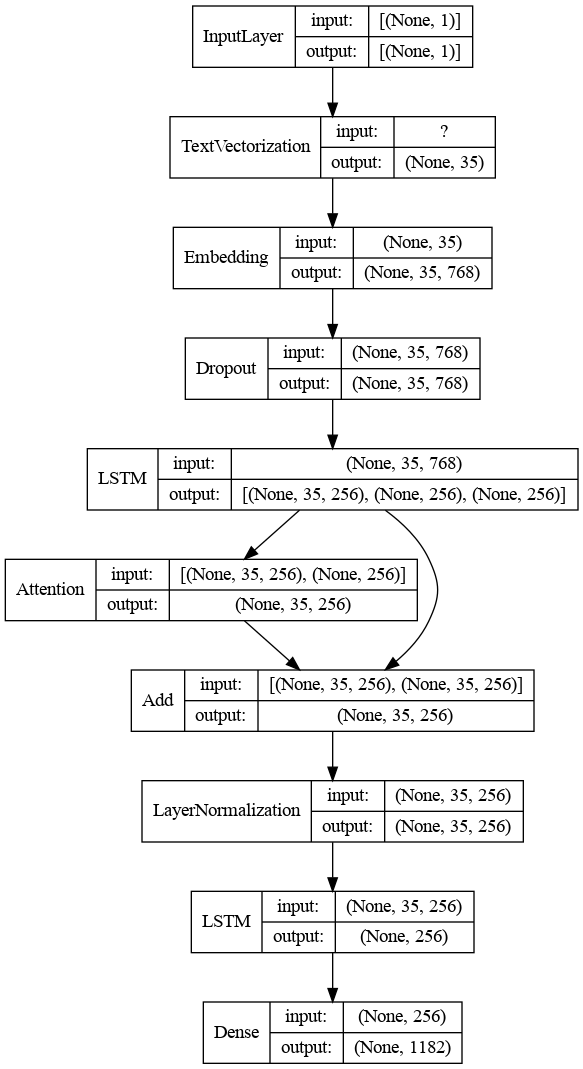

In [58]:
plot_model(LSTM_Dropout_SelfAttention_2, show_shapes=True, show_layer_names=False)

In [59]:
input_layer = Input(shape=(1,), dtype=tf.string)
_vectorize_layer = vectorize_layer(input_layer)
embedding_layer = Embedding(total_words, 768, mask_zero=True)(_vectorize_layer)
dropout_layer = Dropout(0.3)(embedding_layer)

def encoder_stack_attention(input, lstm_units):
    lstm_layer, lstm_hidden_state, _ = LSTM(lstm_units, return_sequences=True, return_state=True, recurrent_regularizer='l2')(input)
    attention = Attention(use_scale=True)([lstm_layer, lstm_hidden_state])
    add = tf.keras.layers.Add()([attention, lstm_layer])
    norm = tf.keras.layers.LayerNormalization()(add)
    return norm

stack_1 = encoder_stack_attention(dropout_layer, 512)
stack_2 = encoder_stack_attention(stack_1, 512)
add_3 = tf.keras.layers.Add()([stack_1, stack_2])

lstm_layer_3 = LSTM(256)(add_3)
output_layer = Dense(total_words, activation='softmax')(lstm_layer_3)
LSTM_Dropout_SelfAttention_3 = Model(inputs=input_layer, outputs=output_layer)

LSTM_Dropout_SelfAttention_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
other_RNNs["LSTM_Dropout_SelfAttention_3"] = fit_model(LSTM_Dropout_SelfAttention_3, "", batch_size=64, epochs=50, callbacks=[])
LSTM_Dropout_SelfAttention_3.save("models/LSTM_Dropout_SelfAttention_3.keras")

Epoch 1/50
114/114 [==============================] - 16s 100ms/step - loss: 6.8070 - accuracy: 0.1065 - val_loss: 4.9320 - val_accuracy: 0.1953
Epoch 2/50
114/114 [==============================] - 9s 79ms/step - loss: 4.4020 - accuracy: 0.2710 - val_loss: 4.0907 - val_accuracy: 0.3575
Epoch 3/50
114/114 [==============================] - 8s 71ms/step - loss: 3.5846 - accuracy: 0.3694 - val_loss: 3.7650 - val_accuracy: 0.4098
Epoch 4/50
114/114 [==============================] - 9s 77ms/step - loss: 3.0444 - accuracy: 0.4393 - val_loss: 3.5685 - val_accuracy: 0.4440
Epoch 5/50
114/114 [==============================] - 8s 69ms/step - loss: 2.6297 - accuracy: 0.4817 - val_loss: 3.4820 - val_accuracy: 0.4418
Epoch 6/50
114/114 [==============================] - 8s 74ms/step - loss: 2.2941 - accuracy: 0.5328 - val_loss: 3.3669 - val_accuracy: 0.4493
Epoch 7/50
114/114 [==============================] - 8s 69ms/step - loss: 2.0245 - accuracy: 0.5674 - val_loss: 3.2942 - val_accuracy: 0.47

In [60]:
objective_task(LSTM_Dropout_SelfAttention_3)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day with a heart full of gratitude for the dawn of',
 'radiate some and let it be the refuge for weary hearts for',
 'believe that yourself and let your heart be open to the world',
 "life's actual purpose is a testament to the beauty of our's deepest desires",
 'dance through each and every step taken in faith is a step towards witnessing miracles',
 "let your time and energy be the bridge that buloh wetland reserve's vitality singapore",
 'every person is a gift from the universe a reminder of the marvel',
 "our country singapore is a testament to the nation's resilience and unwavering determination",
 "planet earth is a reminder of the preciousness of life's journey and",
 "morning and evening would make it's a gift from canning's history to labrador park"]

In [61]:
LSTM_Dropout_SelfAttention_3.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization_1 (Text  (None, 35)                   0         ['input_4[0][0]']             
 Vectorization)                                                                                   
                                                                                                  
 embedding_6 (Embedding)     (None, 35, 768)              907776    ['text_vectorization_1[6][0]']
                                                                                                  
 dropout_6 (Dropout)         (None, 35, 768)              0         ['embedding_6[0][0]']   

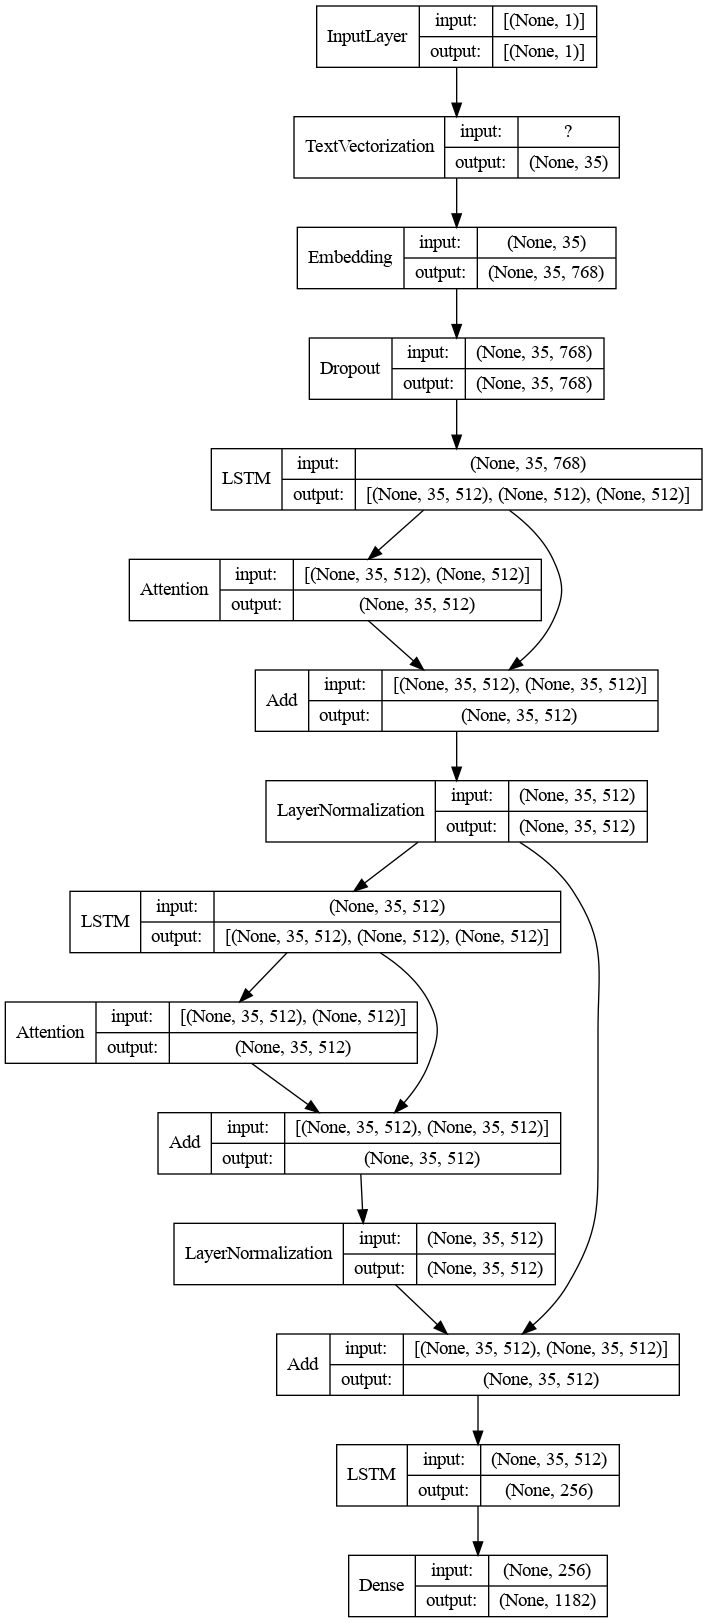

In [62]:
plot_model(LSTM_Dropout_SelfAttention_3, show_shapes=True, show_layer_names=False)

In [63]:
input_layer = Input(shape=(1,), dtype=tf.string)
_vectorize_layer = vectorize_layer(input_layer)
embedding_layer = Embedding(total_words, 768, mask_zero=True)(_vectorize_layer)
dropout_layer = Dropout(0.3)(embedding_layer)

def encoder_stack_attention(input, lstm_units):
    lstm_layer, lstm_hidden_state, _ = LSTM(lstm_units, return_sequences=True, return_state=True, recurrent_regularizer='l2', dropout=0.3)(input)
    attention = Attention(use_scale=True)([lstm_layer, lstm_hidden_state])
    add = tf.keras.layers.Add()([attention, lstm_layer])
    norm = tf.keras.layers.LayerNormalization()(add)
    return norm

stack_1 = encoder_stack_attention(dropout_layer, 512)
stack_2 = encoder_stack_attention(dropout_layer, 512)
stack_3 = encoder_stack_attention(dropout_layer, 512)
add_3 = tf.keras.layers.Concatenate()([stack_1, stack_2, stack_3])

lstm_layer_3 = LSTM(512)(add_3)
output_layer = Dense(total_words, activation='softmax')(lstm_layer_3)
LSTM_Dropout_SelfAttention_4 = Model(inputs=input_layer, outputs=output_layer)

early_stopping = EarlyStopping(
    monitor="loss",
    start_from_epoch=0,
    patience=5,
    min_delta=0.01,
    mode="min",
    restore_best_weights=True
)

LSTM_Dropout_SelfAttention_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
other_RNNs["LSTM_Dropout_SelfAttention_4"] = fit_model(LSTM_Dropout_SelfAttention_4, "", batch_size=64, epochs=50, callbacks=[early_stopping])
LSTM_Dropout_SelfAttention_4.save("models/LSTM_Dropout_SelfAttention_4.keras")

Epoch 1/50
29/29 [==============================] - 13s 220ms/step - loss: 12.0225 - accuracy: 0.1235 - val_loss: 6.4230 - val_accuracy: 0.2220
Epoch 2/50
29/29 [==============================] - 4s 127ms/step - loss: 5.0206 - accuracy: 0.2772 - val_loss: 4.2409 - val_accuracy: 0.3682
Epoch 3/50
29/29 [==============================] - 4s 126ms/step - loss: 3.6241 - accuracy: 0.3754 - val_loss: 3.7033 - val_accuracy: 0.4248
Epoch 4/50
29/29 [==============================] - 4s 152ms/step - loss: 2.9288 - accuracy: 0.4468 - val_loss: 3.4494 - val_accuracy: 0.4536
Epoch 5/50
29/29 [==============================] - 8s 253ms/step - loss: 2.4454 - accuracy: 0.5098 - val_loss: 3.2707 - val_accuracy: 0.4632
Epoch 6/50
29/29 [==============================] - 5s 165ms/step - loss: 2.0782 - accuracy: 0.5598 - val_loss: 3.1756 - val_accuracy: 0.4803
Epoch 7/50
29/29 [==============================] - 4s 144ms/step - loss: 1.7766 - accuracy: 0.6135 - val_loss: 3.0939 - val_accuracy: 0.4899
Epoc

In [64]:
objective_task(LSTM_Dropout_SelfAttention_4)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day is a fresh canvas paint it with vibrant strokes of',
 'radiate some and let it be the guiding star of your life',
 'believe that yourself and you are stronger think than yourself and you',
 "life's actual purpose is a symphony of joy in the heart of this lion",
 'dance through each and every planted is a reminder of the cycles of life on',
 "let your time and energy be the notes of your song of our planet's",
 "every person is a reminder of the cycles of life on our's",
 "our country singapore is's a testament to diversity buloh's the of biodiversity",
 "planet earth is's a testament to our's are the storytellers of",
 "morning and evening would make it's a fresh canvas paint it with arms the that"]

In [65]:
LSTM_Dropout_SelfAttention_4.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization_1 (Text  (None, 35)                   0         ['input_5[0][0]']             
 Vectorization)                                                                                   
                                                                                                  
 embedding_7 (Embedding)     (None, 35, 768)              907776    ['text_vectorization_1[7][0]']
                                                                                                  
 dropout_7 (Dropout)         (None, 35, 768)              0         ['embedding_7[0][0]']   

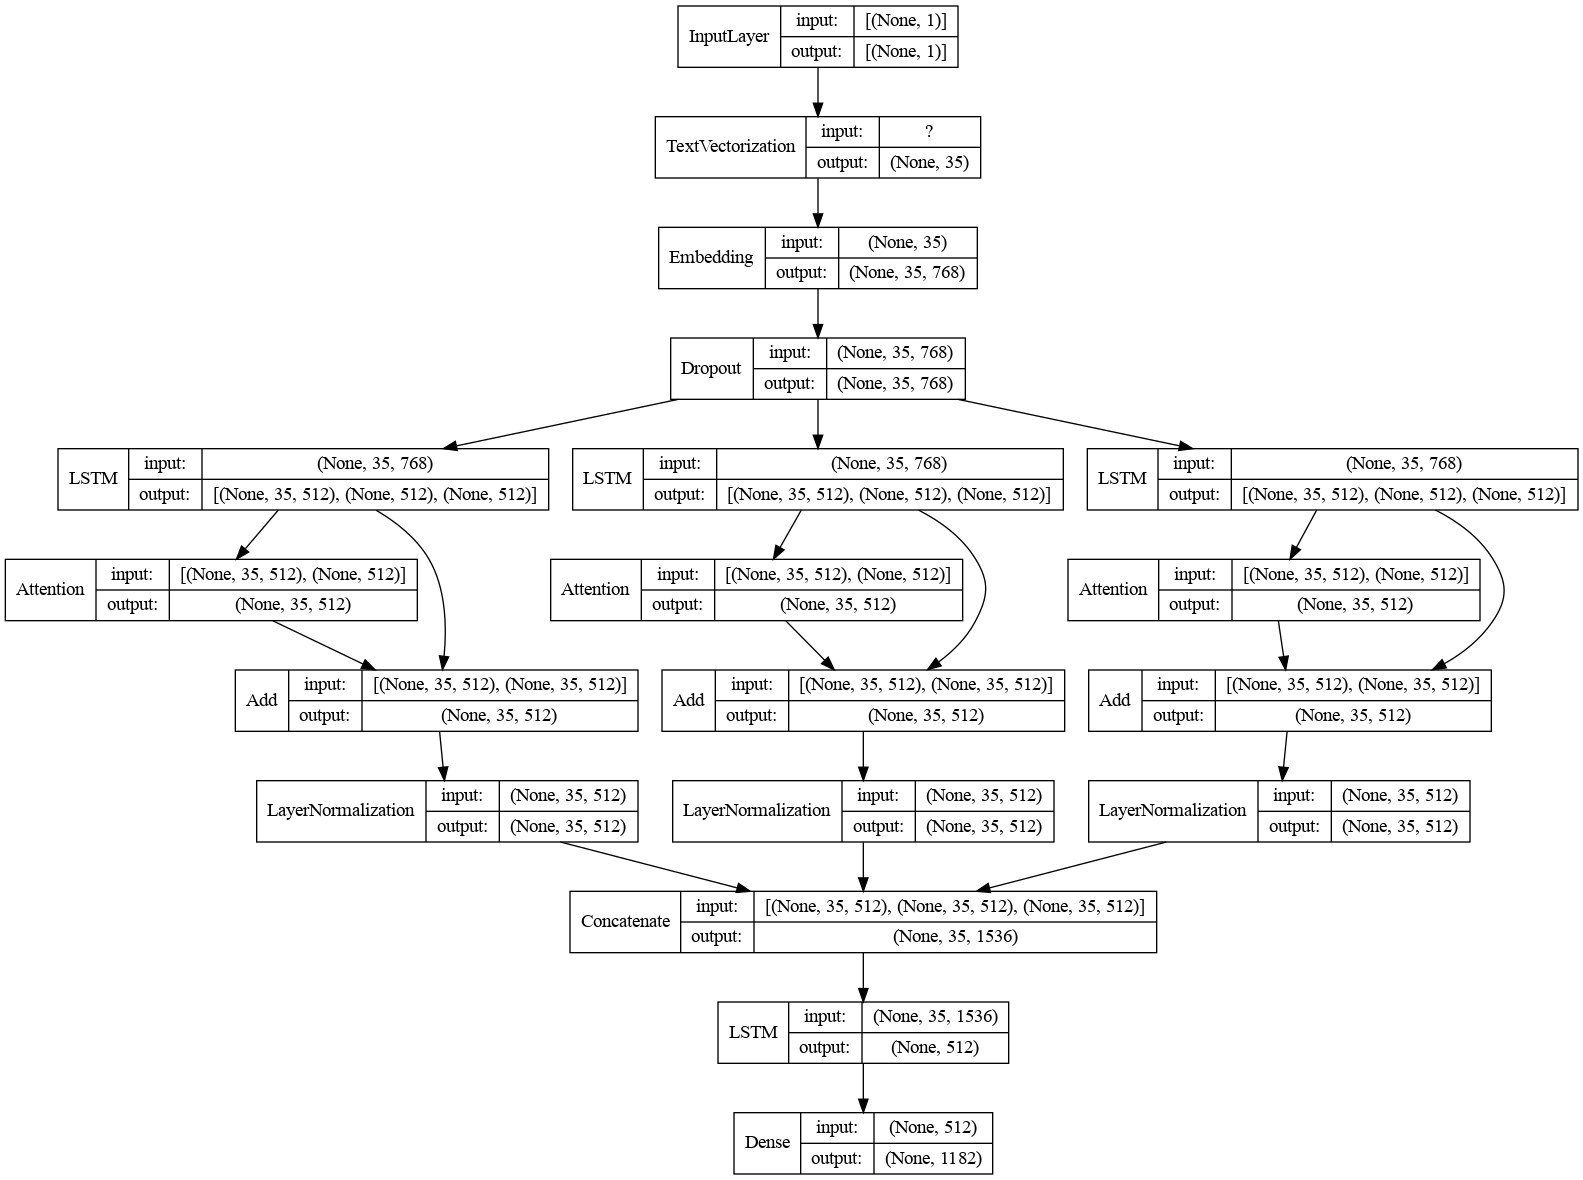

In [66]:
plot_model(LSTM_Dropout_SelfAttention_4, show_shapes=True, show_layer_names=False)

In [67]:
input_layer = Input(shape=(1,), dtype=tf.string)
_vectorize_layer = vectorize_layer(input_layer)
embedding_layer = Embedding(total_words, 768, mask_zero=True)(_vectorize_layer)
dropout_layer = Dropout(0.3)(embedding_layer)

def encoder_stack_attention_bidirectional(input, lstm_units):
    lstm_layer, lstm_hidden_state, _, lstm_rev_hidden_state, _ = Bidirectional(LSTM(lstm_units, return_state=True, recurrent_regularizer='l2', dropout=0.3))(input)
    concat = tf.keras.layers.Concatenate()([lstm_hidden_state, lstm_rev_hidden_state])
    attention = Attention(use_scale=True)([lstm_layer, concat])
    add = tf.keras.layers.Add()([attention, lstm_layer])
    norm = tf.keras.layers.LayerNormalization()(add)
    ffn = Dense(1000, activation="relu")(norm)
    return ffn

stack_1 = encoder_stack_attention_bidirectional(dropout_layer, 512)
stack_2 = encoder_stack_attention_bidirectional(dropout_layer, 512)
stack_3 = encoder_stack_attention_bidirectional(dropout_layer, 512)
add_3 = tf.keras.layers.Concatenate()([stack_1, stack_2, stack_3])

output_layer = Dense(total_words, activation='softmax')(add_3)
LSTM_Dropout_SelfAttention_5 = Model(inputs=input_layer, outputs=output_layer)

early_stopping = EarlyStopping(
    monitor="loss",
    start_from_epoch=0,
    patience=5,
    min_delta=0.01,
    mode="min",
    restore_best_weights=True
)

LSTM_Dropout_SelfAttention_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
other_RNNs["LSTM_Dropout_SelfAttention_5"] = fit_model(LSTM_Dropout_SelfAttention_5, "", batch_size=64, epochs=50, callbacks=[early_stopping])
LSTM_Dropout_SelfAttention_5.save("models/LSTM_Dropout_SelfAttention_5.keras")

Epoch 1/50
114/114 [==============================] - 23s 113ms/step - loss: 8.5548 - accuracy: 0.2580 - val_loss: 4.0345 - val_accuracy: 0.3671
Epoch 2/50
114/114 [==============================] - 9s 83ms/step - loss: 3.2672 - accuracy: 0.3975 - val_loss: 3.6875 - val_accuracy: 0.4088
Epoch 3/50
114/114 [==============================] - 9s 82ms/step - loss: 2.4472 - accuracy: 0.4872 - val_loss: 3.6825 - val_accuracy: 0.4365
Epoch 4/50
114/114 [==============================] - 9s 78ms/step - loss: 1.9570 - accuracy: 0.5478 - val_loss: 3.7686 - val_accuracy: 0.4664
Epoch 5/50
114/114 [==============================] - 9s 79ms/step - loss: 1.6380 - accuracy: 0.5990 - val_loss: 3.9891 - val_accuracy: 0.4472
Epoch 6/50
114/114 [==============================] - 9s 75ms/step - loss: 1.4298 - accuracy: 0.6492 - val_loss: 4.2173 - val_accuracy: 0.4632
Epoch 7/50
114/114 [==============================] - 9s 76ms/step - loss: 1.2596 - accuracy: 0.6930 - val_loss: 4.1476 - val_accuracy: 0.47

In [70]:
objective_task(LSTM_Dropout_SelfAttention_5)

  0%|          | 0/10 [00:00<?, ?it/s]

["embrace each day is a gift to the soul of our planet's",
 'radiate some and let it be the wildfire that sparks change and',
 'believe that you to the path to your purpose and let your',
 "life's actual purpose is the symphony of laughter and let it is the symphony",
 'dance through each and every let your heart lead the way for it knows the',
 'let your time and energy it is the beacon that brightens the world around you',
 'every person is a reminder of the hope and potential within our planet',
 "our country singapore is a testament to the nation's resilience and unwavering determination",
 "planet earth is a symphony of life's garden flourishes when watered with",
 "morning and evening would make it is the of a life's journey for it is"]

In [71]:
LSTM_Dropout_SelfAttention_5.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization_1 (Text  (None, 35)                   0         ['input_6[0][0]']             
 Vectorization)                                                                                   
                                                                                                  
 embedding_8 (Embedding)     (None, 35, 768)              907776    ['text_vectorization_1[8][0]']
                                                                                                  
 dropout_8 (Dropout)         (None, 35, 768)              0         ['embedding_8[0][0]']   

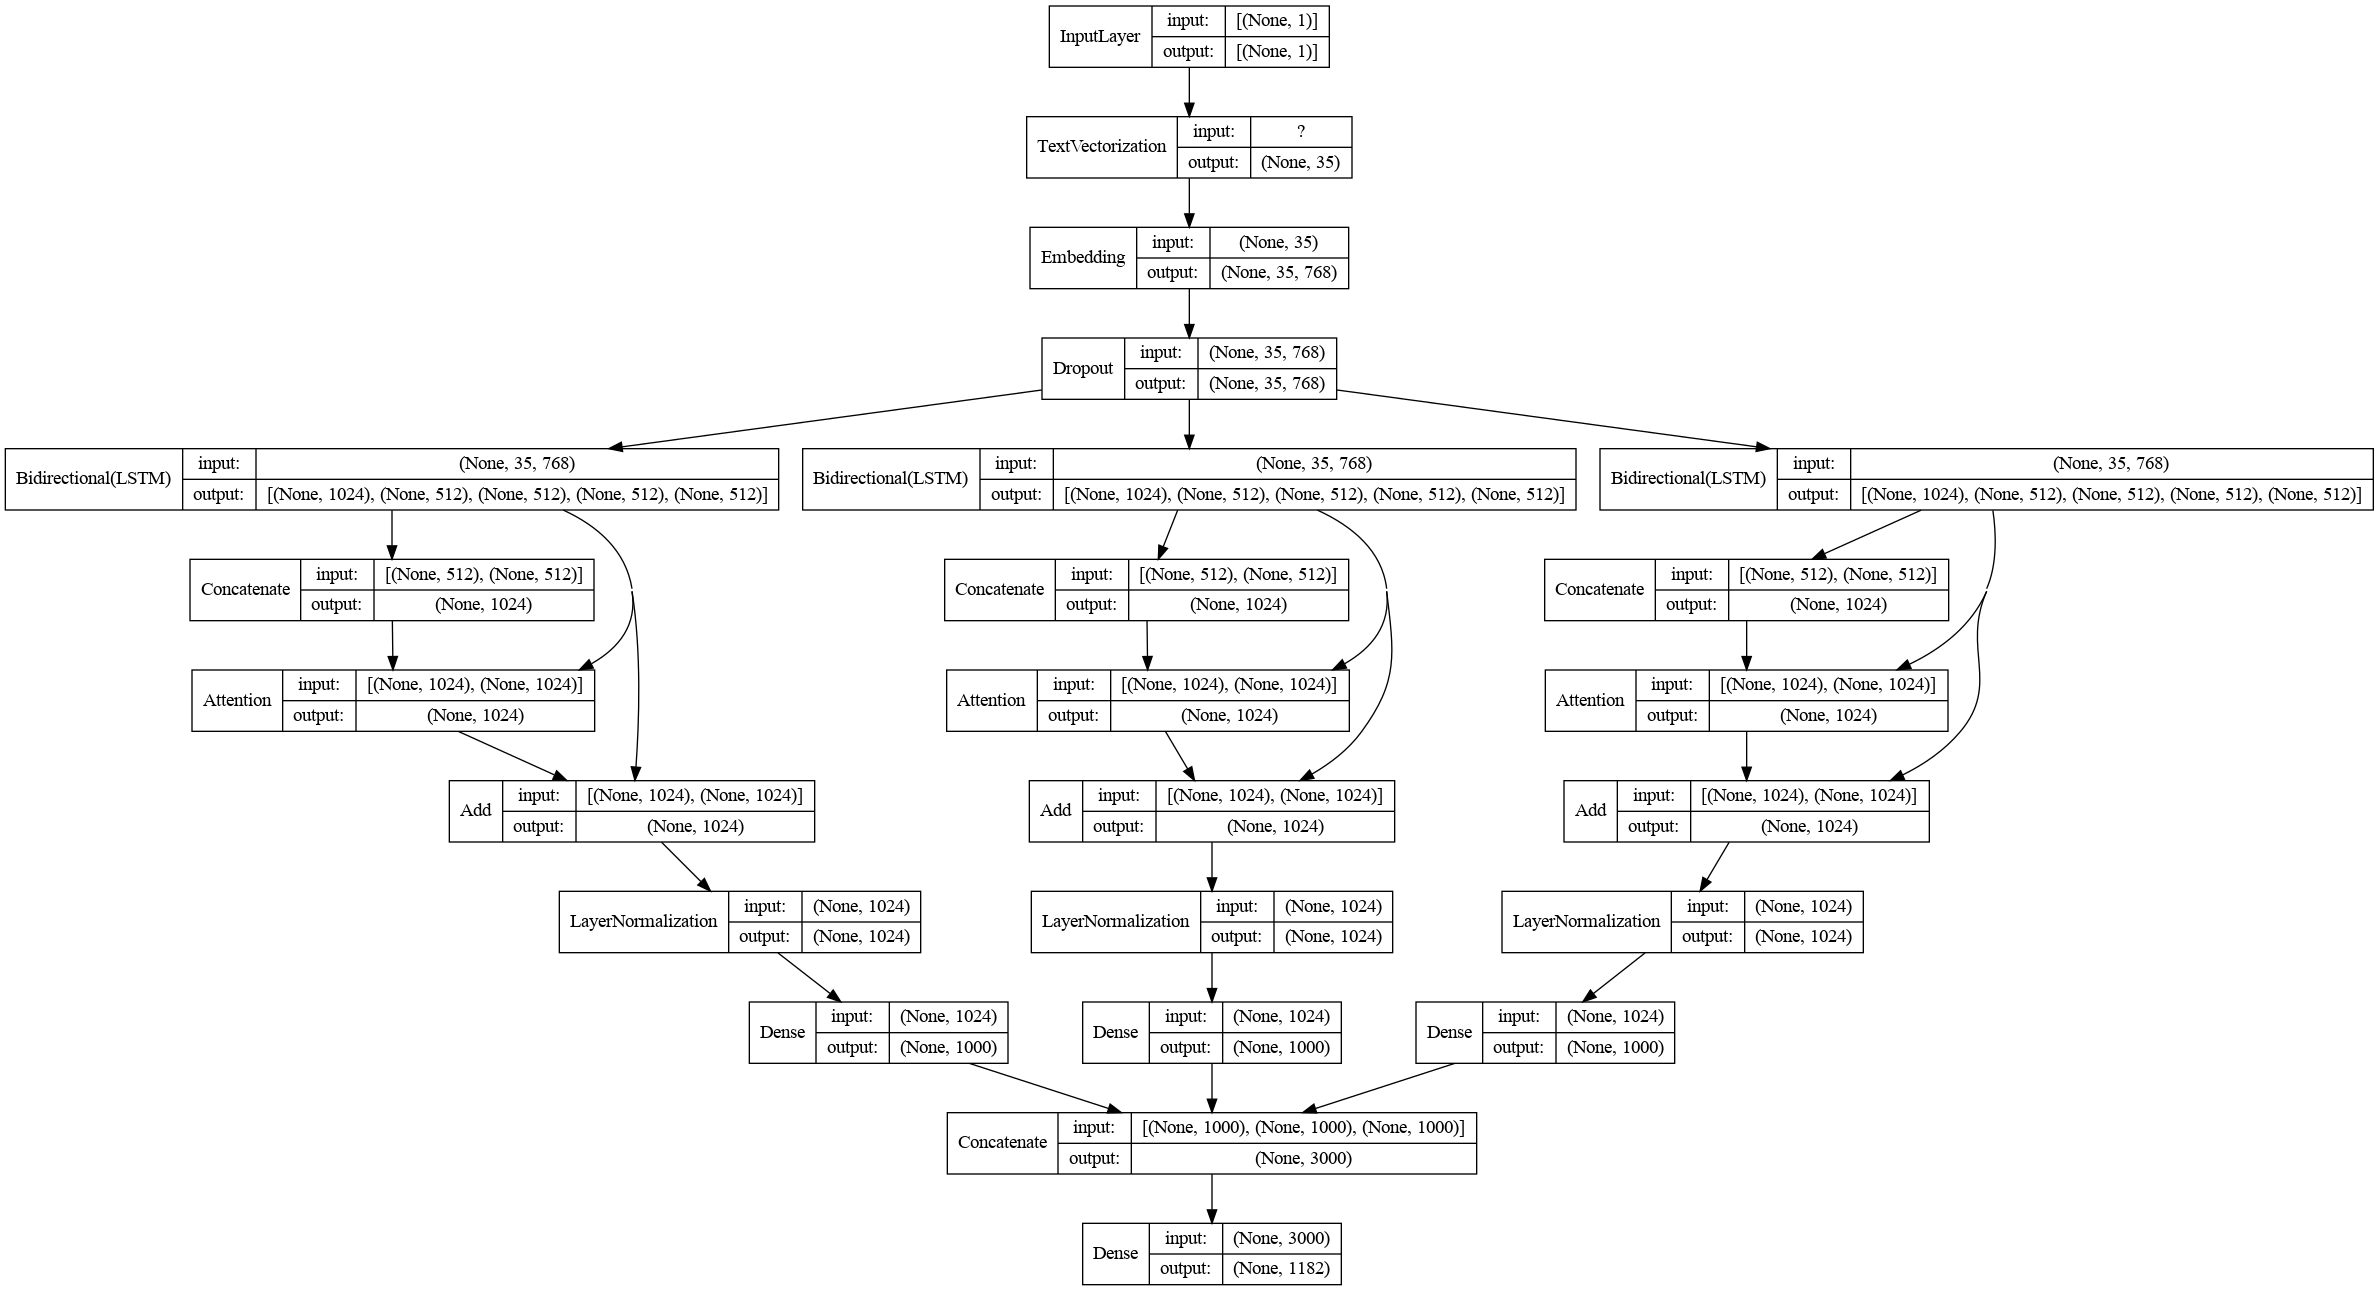

In [72]:
plot_model(LSTM_Dropout_SelfAttention_5, show_shapes=True, show_layer_names=False)

In [74]:
other_RNN_scores = {}

In [47]:
other_RNN_scores = json.load(open("other_RNN_scores.json", "r"))

In [78]:
LSTM_Dropout_256 = load_model("models/LSTM_Dropout_256.keras")
other_RNN_scores["LSTM_Dropout_256"] = calculate_scoring_metrics(LSTM_Dropout_256)
json.dump(other_RNN_scores, open("other_RNN_scores.json", "w"))

simple_Bi_LSTM_256 = load_model("models/Bi_LSTM_256.keras")
other_RNN_scores["simple_Bi_LSTM_256"] = calculate_scoring_metrics(simple_Bi_LSTM_256)
json.dump(other_RNN_scores, open("other_RNN_scores.json", "w"))

Bi_LSTM_Dropout_256 = load_model("models/Bi_LSTM_Dropout_256.keras")
other_RNN_scores["Bi_LSTM_Dropout_256"] = calculate_scoring_metrics(Bi_LSTM_Dropout_256)
json.dump(other_RNN_scores, open("other_RNN_scores.json", "w"))

Bi_LSTM_2_Dropout_256 = load_model("models/Bi_LSTM_2_Dropout_256.keras")
other_RNN_scores["Bi_LSTM_2_Dropout_256"] = calculate_scoring_metrics(Bi_LSTM_2_Dropout_256)
json.dump(other_RNN_scores, open("other_RNN_scores.json", "w"))

LSTM_Dropout_SelfAttention_256 = load_model("models/LSTM_Dropout_SelfAttention_256.keras")
other_RNN_scores["LSTM_Dropout_SelfAttention_256"] = calculate_scoring_metrics(LSTM_Dropout_SelfAttention_256)
json.dump(other_RNN_scores, open("other_RNN_scores.json", "w"))

LSTM_Dropout_SelfAttention_2 = load_model("models/LSTM_Dropout_SelfAttention_2.keras")
other_RNN_scores["LSTM_Dropout_SelfAttention_2"] = calculate_scoring_metrics(LSTM_Dropout_SelfAttention_2)
json.dump(other_RNN_scores, open("other_RNN_scores.json", "w"))

LSTM_Dropout_SelfAttention_3 = load_model("models/LSTM_Dropout_SelfAttention_3.keras")
other_RNN_scores["LSTM_Dropout_SelfAttention_3"] = calculate_scoring_metrics(LSTM_Dropout_SelfAttention_3)
json.dump(other_RNN_scores, open("other_RNN_scores.json", "w"))

LSTM_Dropout_SelfAttention_4 = load_model("models/LSTM_Dropout_SelfAttention_4.keras")
other_RNN_scores["LSTM_Dropout_SelfAttention_4"] = calculate_scoring_metrics(LSTM_Dropout_SelfAttention_4)
json.dump(other_RNN_scores, open("other_RNN_scores.json", "w"))

LSTM_Dropout_SelfAttention_5 = load_model("models/LSTM_Dropout_SelfAttention_5.keras")
other_RNN_scores["LSTM_Dropout_SelfAttention_5"] = calculate_scoring_metrics(LSTM_Dropout_SelfAttention_5)
json.dump(other_RNN_scores, open("other_RNN_scores.json", "w"))

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

In [125]:
pd.concat([pd.DataFrame(display_scores(all_RNN_scores)).transpose(), pd.DataFrame(display_scores(other_RNN_scores)).transpose()])

,mean_mistakes,bleu
SimpleRNN,0.258278,0.076388
GRU,0.350993,0.075116
LSTM,0.860927,0.073228
LSTM_128,0.072848,0.915979
LSTM_128_2,0.072848,0.896586
LSTM_256,0.125828,0.914997
LSTM_512,0.086093,0.926191
LSTM_1024,0.125828,0.926404
LSTM_256_1gram,0.112583,0.923157
LSTM_256_2gram,0.225166,0.871987


In [41]:
# loading

simple_RNN = load_model("models/SimpleRNN.keras")
simple_GRU = load_model("models/GRU.keras")
simple_LSTM = load_model("models/LSTM.keras")
simple_LSTM_128 = load_model("models/LSTM_128.keras")
simple_LSTM_128_2 = load_model("models/LSTM_128_2.keras")
simple_LSTM_256 = load_model("models/LSTM_256.keras")
simple_LSTM_512 = load_model("models/LSTM_512.keras")
simple_LSTM_1024 = load_model("models/LSTM_1024.keras")

LSTM_Dropout_256 = load_model("models/LSTM_Dropout_256.keras")
simple_Bi_LSTM_256 = load_model("models/Bi_LSTM_256.keras")
Bi_LSTM_Dropout_256 = load_model("models/Bi_LSTM_Dropout_256.keras")
Bi_LSTM_2_Dropout_256 = load_model("models/Bi_LSTM_2_Dropout_256.keras")

LSTM_Dropout_SelfAttention_256 = load_model("models/LSTM_Dropout_SelfAttention_256.keras")
LSTM_Dropout_SelfAttention_2 = load_model("models/LSTM_Dropout_SelfAttention_2.keras")
LSTM_Dropout_SelfAttention_3 = load_model("models/LSTM_Dropout_SelfAttention_3.keras")
LSTM_Dropout_SelfAttention_4 = load_model("models/LSTM_Dropout_SelfAttention_4.keras")
LSTM_Dropout_SelfAttention_5 = load_model("models/LSTM_Dropout_SelfAttention_5.keras")

In [42]:
final_scores = {}

print("simple_RNN")
final_scores["simple_RNN"] = score_bleu(objective_task(simple_RNN), verbose=1)
print("simple_GRU")
final_scores["simple_GRU"] = score_bleu(objective_task(simple_GRU), verbose=1)
print("simple_LSTM")
final_scores["simple_LSTM"] = score_bleu(objective_task(simple_LSTM), verbose=1)
print("simple_LSTM_128")
final_scores["simple_LSTM_128"] = score_bleu(objective_task(simple_LSTM_128), verbose=1)
print("simple_LSTM_128_2")
final_scores["simple_LSTM_128_2"] = score_bleu(objective_task(simple_LSTM_128_2), verbose=1)
print("simple_LSTM_256")
final_scores["simple_LSTM_256"] = score_bleu(objective_task(simple_LSTM_256), verbose=1)
print("simple_LSTM_512")
final_scores["simple_LSTM_512"] = score_bleu(objective_task(simple_LSTM_512), verbose=1)
print("simple_LSTM_1024")
final_scores["simple_LSTM_1024"] = score_bleu(objective_task(simple_LSTM_1024), verbose=1)

print("LSTM_Dropout_256")
final_scores["LSTM_Dropout_256"] = score_bleu(objective_task(LSTM_Dropout_256), verbose=1)
print("simple_Bi_LSTM_256")
final_scores["simple_Bi_LSTM_256"] = score_bleu(objective_task(simple_Bi_LSTM_256), verbose=1)
print("Bi_LSTM_Dropout_256")
final_scores["Bi_LSTM_Dropout_256"] = score_bleu(objective_task(Bi_LSTM_Dropout_256), verbose=1)
print("Bi_LSTM_2_Dropout_256")
final_scores["Bi_LSTM_2_Dropout_256"] = score_bleu(objective_task(Bi_LSTM_2_Dropout_256), verbose=1)

print("LSTM_Dropout_SelfAttention_256")
final_scores["LSTM_Dropout_SelfAttention_256"] = score_bleu(objective_task(LSTM_Dropout_SelfAttention_256), verbose=1)
print("LSTM_Dropout_SelfAttention_2")
final_scores["LSTM_Dropout_SelfAttention_2"] = score_bleu(objective_task(LSTM_Dropout_SelfAttention_2), verbose=1)
print("LSTM_Dropout_SelfAttention_3")
final_scores["LSTM_Dropout_SelfAttention_3"] = score_bleu(objective_task(LSTM_Dropout_SelfAttention_3), verbose=1)
print("LSTM_Dropout_SelfAttention_4")
final_scores["LSTM_Dropout_SelfAttention_4"] = score_bleu(objective_task(LSTM_Dropout_SelfAttention_4), verbose=1)
print("LSTM_Dropout_SelfAttention_5")
final_scores["LSTM_Dropout_SelfAttention_5"] = score_bleu(objective_task(LSTM_Dropout_SelfAttention_5), verbose=1)

simple_RNN


  0%|          | 0/10 [00:00<?, ?it/s]

embrace each day is a gift a reminder of the marvel of existence, 0.9306048591020996
radiate some and let it be the foundation of your strength and, 0.8265168183793802
believe that this morning let your heart be the compass that leads, 0.8931539818068694
life's actual purpose is a testament to the beauty of our uniqueness's journey, 0.6508911374939451
dance through each and every day is a gift a reminder of the marvel of, 0.8142441551106129
let your time and energy is contagious pursuit with conquering any obstacle that comes your, 0.48415247130346006
every person is an investment in your future of our planet's future, 0.7795149903947967
our country singapore is a brushstroke on the symphony of life and let it, 0.7138957847176474
planet earth is a testament to the past of coastal communities and wildlife, 0.6360188027707555
morning and evening would make it with the brushstrokes of survival where life unfolds its drama, 0.6262844962765468
simple_GRU


  0%|          | 0/10 [00:00<?, ?it/s]

embrace each day is a gift to the soul of our planet's, 0.9306048591020996
radiate some for it is the heartbeat of humanity for it sets, 0.6132297420585351
believe that yourself and you will be a source of light for, 0.8446928838416219
life's actual purpose is the treasure chest of experience and survival survival where life, 0.5067309892897294
dance through each and every step we take towards our dreams and aspirations and dreams, 0.6930977286178778
let your time and energy flourish flourish flourish flourish flourish flourish adaptation adaptation adaptation adaptation, 6.373704167435469e-155
every person is a gem in the treasury the treasury of cherished memories, 0.8801117367933934
our country singapore is a testament to life's nature is diverse and breathtaking, 0.7138957847176474
planet earth is a mark of time immemorial immemorial immemorial immemorial immemorial immemorial, 5.675175336138377e-78
morning and evening would make it's nature is a treasure in the world around you, 0

  0%|          | 0/10 [00:00<?, ?it/s]

embrace each day's a gift a reminder of the cycles of life, 0.7691605673134586
radiate some for it is the key to unlocking your true potential, 0.8265168183793802
believe that yourself and you will be a source of light for, 0.8446928838416219
life's actual purpose is a testament to the world creating waves of life and, 0.6113438261084554
dance through each and every moment of your dreams is a gift to the promise, 0.5266403878479265
let your time and energy be the bridge that connects hearts together in someone's, 0.49862067651615033
every person is a gift a reminder of the marvel of existence and, 0.8801117367933934
our country singapore is a picture of a nation reaching for the stars of, 0.6725080050576688
planet earth is a picture of a nation reaching for the stars of, 0.7315254958027825
morning and evening would make it is a testament to the world around you to change, 0.5093498412990677
simple_LSTM_128


  0%|          | 0/10 [00:00<?, ?it/s]

embrace each day is a fresh start for new beginnings and fresh start, 0.7670387248467656
radiate some and let it be the foundation of your strength and, 0.8265168183793802
believe that you encounter carries a story of your journey a tale, 0.7972714256536028
life's actual purpose is the harmonious blend of our dreams and reality and deeds, 0.6665865240112949
dance through each and every day is a pledge to tread lightly on our planet, 0.787511062110268
let your time and energy be the cradle of biodiversity and joy that others find, 0.43748114312246444
every person is a canvas for new beginnings and you are not alone, 0.6950150297221263
our country singapore is the cradle from which life springs forth life's adaptability, 0.6298129992394241
planet earth is the nurseries of biodiversity and life for many coastal species, 0.7419446627365011
morning and evening would make it with the beauty in our heart's beauty is more, 0.33649324423301513
simple_LSTM_128_2


  0%|          | 0/10 [00:00<?, ?it/s]

embrace each day for it is a canvas of your being beginnings and, 0.4296943523820148
radiate some and let it be the bridge that mends hearts that, 0.7468422531048421
believe that yourself and you are a future in the darkness that, 8.675159020560393e-78
life's actual purpose is a fresh start and new beginnings take take moments towards, 0.45180100180492244
dance through each and every heart they hold the beauty in every day and journey, 0.46257998903482245
let your time and energy be the sword that cuts through fear and joy in, 0.535802786369768
every person is a tapestry it with threads of love and hope and, 0.6529942057256104
our country singapore is a tapestry woven with threads of life's tenacity are, 0.6953371688722156
planet earth is a tapestry of grass and vibrant step and joy in, 6.969869295982248e-78
morning and evening would make it with your heart reminding you of your day's journey, 0.46825687910244024
simple_LSTM_256


  0%|          | 0/10 [00:00<?, ?it/s]

embrace each day for it is the rhythm of resilience and possibility it, 0.6115380576901023
radiate some and let it be the foundation of your strength and, 0.8265168183793802
believe that you are capable of extraordinary things things world class around, 0.6000342906130847
life's actual purpose is the pursuit of our heart's deepest desires desires and, 0.6223329772884784
dance through each and every moment savoring the beauty it holds the promise of new, 0.7380411773078261
let your time and energy be the compass that guides you to your purpose and, 0.6622152291011697
every person is a reminder of the preciousness of life and let it, 0.8512160931922469
our country singapore is a canvas for it with vibrant experiences life's vitality, 0.4697698451116114
planet earth is a testament to the nation's serenity and let your, 0.6360188027707555
morning and evening would make it with joy in your heart and you will conquer anything, 0.42311785416105785
simple_LSTM_512


  0%|          | 0/10 [00:00<?, ?it/s]

embrace each day is a fresh canvas paint it with vibrant strokes of, 0.9306048591020996
radiate some and let it be the bridge that mends hearts hearts, 0.7292571723872933
believe that you are the architect of your destiny's journey a, 0.7102992180127422
life's actual purpose is the classroom where we learn to love unconditionally unconditionally unconditionally, 0.6100034457014365
dance through each and every moment it is a gift of the soul a release, 0.548722968170868
let your time and energy be the light that brightens someone's day leaving a, 0.7115965735877551
every person is a setup for a glorious comeback a light in the, 0.7348889200874658
our country singapore is the wide open canvases of nature's palette and renewal, 0.6182518852201093
planet earth is the compass that guides you home to life's journey, 0.615137167087256
morning and evening would make it well what you meet in the world of possibilities and, 6.002266945004367e-78
simple_LSTM_1024


  0%|          | 0/10 [00:00<?, ?it/s]

embrace each day is a fresh canvas paint it with vibrant strokes of, 0.9306048591020996
radiate some and let it be the anchor in the storms of, 0.8265168183793802
believe that you are the architect of your destiny and let your, 0.7102992180127422
life's actual purpose is the pursuit of our heart's deepest desires and dreams, 0.6508911374939451
dance through each and every how it brings your world with brightness and gratitude be, 0.342347495586902
let your time and energy the way for it knows the path to true happiness, 0.7115965735877551
every person is a setup for a glorious comeback for the future of, 0.7175852914772134
our country singapore is the veins that pulse with life's vitality and renewal, 0.6182518852201093
planet earth is the melody of a life well lived the atmosphere from, 0.6529942057256104
morning and evening would make it with the fruits of love and joy in the world, 0.547332024239071
LSTM_Dropout_256


  0%|          | 0/10 [00:00<?, ?it/s]

embrace each day for it is the heartbeat of humanity and soul on, 0.6076795808137692
radiate some and let it be the anchor in the storms of, 0.8265168183793802
believe that you are a work of art in progress and determination, 0.7972714256536028
life's actual purpose is a classroom where we learn to love ourselves go go, 0.6223329772884784
dance through each and every moment it holds the beauty of every moment savoring the, 0.38233014078302996
let your time and energy be your wings and force that transforms the world around, 0.47156632089063605
every person is a reminder of the hope and potential within your potential, 0.7691605673134586
our country singapore is the wide open canvases of nature's palette and vibrant, 0.6182518852201093
planet earth is the cradle of biodiversity and resilience and resilience of hope, 0.5801559414528517
morning and evening would make it with purpose and determination and force will follow the world, 0.2588173346314121
simple_Bi_LSTM_256


  0%|          | 0/10 [00:00<?, ?it/s]

embrace each day is a fresh canvas paint it with vibrant strokes of, 0.9306048591020996
radiate some and let it be the bridge that mends hearts and, 0.7691605673134586
believe that falls yourself for it is the architect of your destiny, 0.6076795808137692
life's actual purpose is a tapestry woven with threads of love and resilience and, 0.6665865240112949
dance through each and every moment savoring the beauty it holds the promise of life, 0.684694991173804
let your time and energy be the compass that guides your way for it knows, 0.632708767532676
every person is a reminder of the preciousness of life and stability a, 0.7419446627365011
our country singapore is a testament to the beauty and resilience of the future, 0.6003124062338072
planet earth is the cradle of life's beautiful chaos desires with grace, 0.4172261448611506
morning and evening would make it with the beauty of the world one it's journey, 0.32172944208038085
Bi_LSTM_Dropout_256


  0%|          | 0/10 [00:00<?, ?it/s]

embrace each day is a canvas for it is the melody of a, 0.8512160931922469
radiate some and let it be the bridge that mends hearts of, 0.7691605673134586
believe that you'll attract falls rhythmic nurseries rhythmic cycles nurseries architect, 4.742124357482983e-78
life's actual purpose is a testament to the beauty of love and joy will, 0.6585051938990261
dance through each and every let gratitude is your guiding star and love for it, 7.782131669079476e-78
let your time and energy be the compass that guides you home your way for, 0.535802786369768
every person is a reminder of the world of life on our planet, 0.6950150297221263
our country singapore is the cradle of biodiversity and resilience and unwavering vision of, 0.6238986072117501
planet earth is the heartbeat of a nation life unfolds its drama from, 0.5747078645171894
morning and evening would make it's day with purpose and love let your spirit and, 7.262123179505913e-78
Bi_LSTM_2_Dropout_256


  0%|          | 0/10 [00:00<?, ?it/s]

embrace each day is a gift a symbol of endless potential to words, 0.7175852914772134
radiate some and let it be the melody of your life's, 0.8265168183793802
believe that let your heart be the change for others find the, 0.5193071778680676
life's actual purpose is the music that our dreams and reality and passion those, 0.43000007605628365
dance through each and every sunrise it holds its magic that love and joy you, 8.362444697084453e-78
let your time and energy be the source of innovation and transformation you stand tall, 0.5607900239988007
every person is a reminder of the hope and potential within our planet, 0.8801117367933934
our country singapore is the theaters of survival where life unfolds its drama singapore, 0.6725080050576688
planet earth is the heartbeat of our inner strength and wisdom for others, 0.7175852914772134
morning and evening would make it's journey a gift to everyone you encounter take connections, 0.3784481137591871
LSTM_Dropout_SelfAttention_256


  0%|          | 0/10 [00:00<?, ?it/s]

embrace each day is a chance for adventure for the day ahead a, 0.6652049901111009
radiate some and let it be the foundation of your strength and, 0.8265168183793802
believe that you will be a source of strength for others are, 0.7860753021519787
life's actual purpose is the moments that define us of our planet's vitality, 0.579558149889942
dance through each and every day is a canvas for new beginnings and fresh opportunities, 0.787511062110268
let your time and energy be the bridge that connects hearts together together together and, 0.42728700639623407
every person is a reminder of the hope and potential within our planet, 0.8801117367933934
our country singapore is springs are the wellsprings of life's refreshment and renewal, 0.7226568811456053
planet earth is the cradle of biodiversity and resilience a life's course, 0.7016879391277372
morning and evening would make it well of your journey and adventures a path towards healing, 0.31823566221963034
LSTM_Dropout_SelfAttention_2


  0%|          | 0/10 [00:00<?, ?it/s]

embrace each day with a heart full of gratitude and you'll inspire, 0.8739351325046804
radiate some and let it be the melody of your life's, 0.8265168183793802
believe that skyline positivity for it is the beacon that shores to, 0.6132297420585351
life's actual purpose is the melody of our's deepest desires and receive and, 0.4188216850419828
dance through each and every towards your dreams is an investment in your future in, 0.7012055133086459
let your time and energy from the bay to embrace and let it be the, 0.4066689638009577
every person is a reminder of the world of and let your heart, 0.6076795808137692
our country singapore is's skyline its ambition and vision of tomorrow's beauty, 0.36275382698457337
planet earth is the guardians of coastal species and let it be the, 0.5655095706824206
morning and evening would make it with arms the beauty in every step towards nature is, 0.3784481137591871
LSTM_Dropout_SelfAttention_3


  0%|          | 0/10 [00:00<?, ?it/s]

embrace each day with a heart full of gratitude for the dawn of, 0.7825422900366437
radiate some and let it be the refuge for weary hearts for, 0.7468422531048421
believe that yourself and let your heart be open to the world, 0.8127596564026885
life's actual purpose is a testament to the beauty of our's deepest desires, 0.6218892458282913
dance through each and every step taken in faith is a step towards witnessing miracles, 0.8142441551106129
let your time and energy be the bridge that buloh wetland reserve's vitality singapore, 0.5607900239988007
every person is a gift from the universe a reminder of the marvel, 0.8512160931922469
our country singapore is a testament to the nation's resilience and unwavering determination, 0.7900555574972935
planet earth is a reminder of the preciousness of life's journey and, 0.7641166194509463
morning and evening would make it's a gift from canning's history to labrador park, 0.47735349332944554
LSTM_Dropout_SelfAttention_4


  0%|          | 0/10 [00:00<?, ?it/s]

embrace each day is a fresh canvas paint it with vibrant strokes of, 0.9306048591020996
radiate some and let it be the guiding star of your life, 0.8265168183793802
believe that yourself and you are stronger think than yourself and you, 6.206021746903507e-78
life's actual purpose is a symphony of joy in the heart of this lion, 0.7627414200649782
dance through each and every planted is a reminder of the cycles of life on, 0.722160038719837
let your time and energy be the notes of your song of our planet's, 0.5757575636202255
every person is a reminder of the cycles of life on our's, 0.8070557274927981
our country singapore is's a testament to diversity buloh's the of biodiversity, 0.28387021048806443
planet earth is's a testament to our's are the storytellers of, 0.3087818953963449
morning and evening would make it's a fresh canvas paint it with arms the that, 0.4728708045015879
LSTM_Dropout_SelfAttention_5


  0%|          | 0/10 [00:00<?, ?it/s]

embrace each day is a gift to the melody of a life's, 0.8739351325046804
radiate some and let it be the wildfire that sparks change and, 0.7691605673134586
believe that you to the strength and let it be the beacon, 0.7972714256536028
life's actual purpose is the symphony of laughter and joy in the melody of, 0.6585051938990261
dance through each and every of gratitude moment for it is the rhythm of possibility, 0.632708767532676
let your time and energy it is the beacon that brightens the world around you, 0.7287557921168066
every person is a symphony of joy that reverberates in the heart spreading, 0.8801117367933934
our country singapore is a testament to the nation's resilience and unwavering determination, 0.7900555574972935
planet earth is a symphony of life's garden flourishes when watered with, 0.7641166194509463
morning and evening would make it is the of a life's symphony of laughter for, 0.36271021890216215


In [61]:
final_scores

{'simple_RNN': 0.7355277497356114,
 'simple_GRU': 0.5780742732257673,
 'simple_LSTM': 0.6870470238959906,
 'simple_LSTM_128': 0.6685671634054842,
 'simple_LSTM_128_2': 0.44433086363966356,
 'simple_LSTM_256': 0.6440801145615713,
 'simple_LSTM_512': 0.6208762209357025,
 'simple_LSTM_1024': 0.6708419508824829,
 'LSTM_Dropout_256': 0.5934082992426728,
 'simple_Bi_LSTM_256': 0.6372647945858942,
 'Bi_LSTM_Dropout_256': 0.4708306142225565,
 'Bi_LSTM_2_Dropout_256': 0.5702852534867209,
 'LSTM_Dropout_SelfAttention_256': 0.669484554832527,
 'LSTM_Dropout_SelfAttention_2': 0.5754768947334133,
 'LSTM_Dropout_SelfAttention_3': 0.7221809387951812,
 'LSTM_Dropout_SelfAttention_4': 0.5690359337765315,
 'LSTM_Dropout_SelfAttention_5': 0.6136908310334046}

In [134]:
pd.DataFrame({k: {"bleu": v} for k, v in final_scores.items()}).transpose()

,bleu
simple_RNN,0.735528
simple_GRU,0.578074
simple_LSTM,0.687047
simple_LSTM_128,0.668567
simple_LSTM_128_2,0.444331
simple_LSTM_256,0.644080
simple_LSTM_512,0.620876
simple_LSTM_1024,0.670842
LSTM_Dropout_256,0.593408
simple_Bi_LSTM_256,0.637265


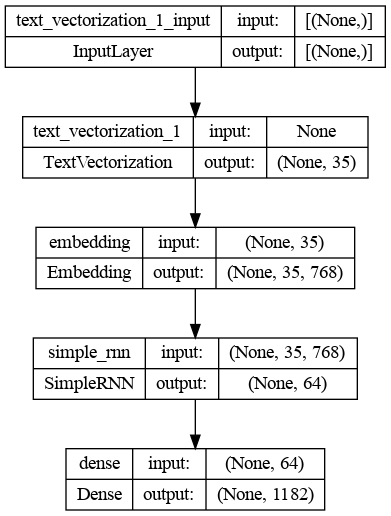

In [67]:
plot_model(simple_RNN, show_shapes=True, show_layer_names=True)

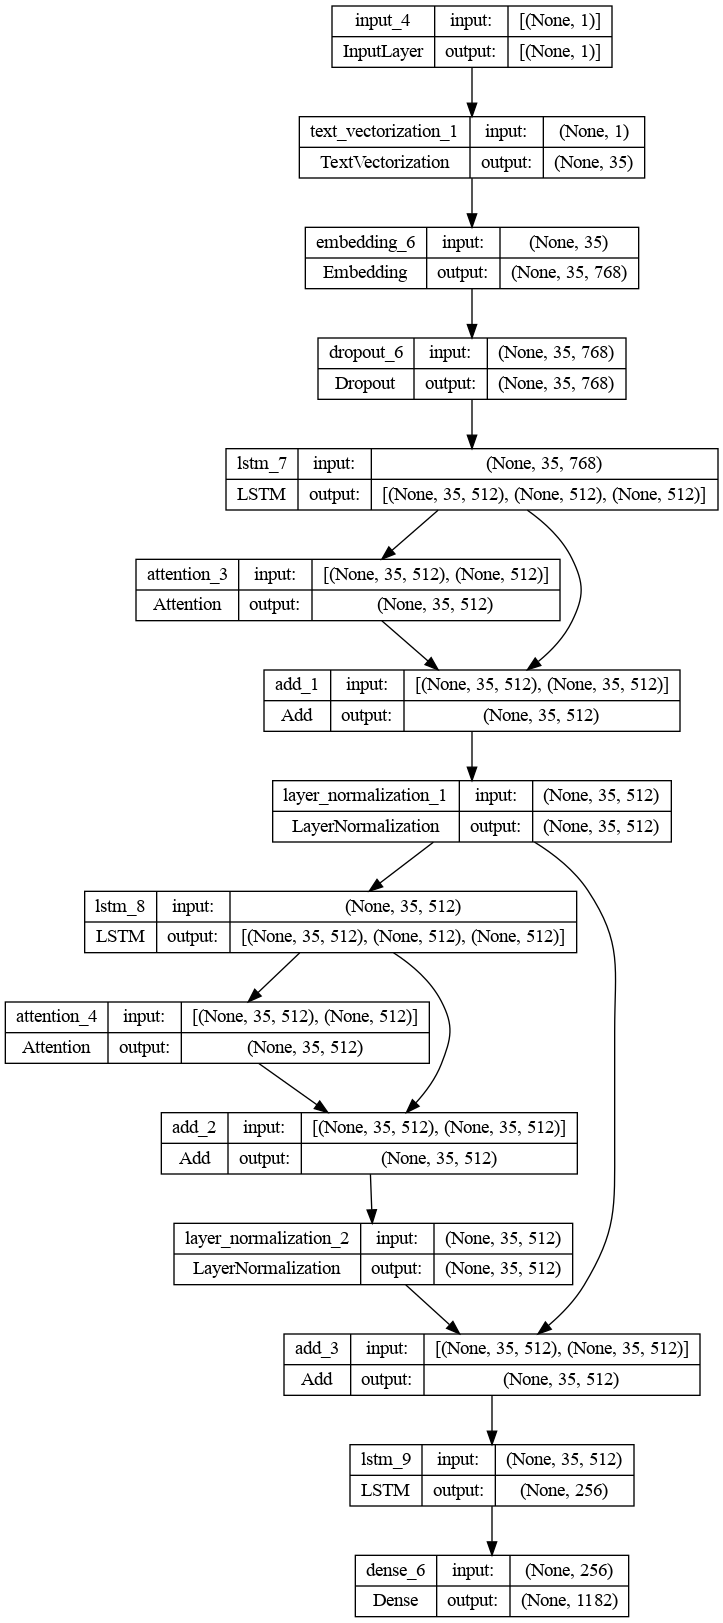

In [59]:
plot_model(LSTM_Dropout_SelfAttention_3, show_shapes=True, show_layer_names=True)

In [137]:
score_bleu(objective_task(simple_RNN), verbose=1)

  0%|          | 0/10 [00:00<?, ?it/s]

embrace each day is a gift a reminder of the marvel of existence, 0.9306048591020996
radiate some and let it be the foundation of your strength and, 0.8265168183793802
believe that this morning let your heart be the compass that leads, 0.8931539818068694
life's actual purpose is a testament to the beauty of our uniqueness's journey, 0.6508911374939451
dance through each and every day is a gift a reminder of the marvel of, 0.8142441551106129
let your time and energy is contagious pursuit with conquering any obstacle that comes your, 0.48415247130346006
every person is an investment in your future of our planet's future, 0.7795149903947967
our country singapore is a brushstroke on the symphony of life and let it, 0.7138957847176474
planet earth is a testament to the past of coastal communities and wildlife, 0.6360188027707555
morning and evening would make it with the brushstrokes of survival where life unfolds its drama, 0.6262844962765468


0.7355277497356114

In [48]:
score_grammar(objective_task(simple_RNN))[0]

  0%|          | 0/10 [00:00<?, ?it/s]

0.0

In [56]:
score_bleu(objective_task(LSTM_Dropout_SelfAttention_3), verbose=1)

  0%|          | 0/10 [00:00<?, ?it/s]

embrace each day with a heart full of gratitude for the dawn of, 0.7825422900366437
radiate some and let it be the refuge for weary hearts for, 0.7468422531048421
believe that yourself and let your heart be open to the world, 0.8127596564026885
life's actual purpose is a testament to the beauty of our's deepest desires, 0.6218892458282913
dance through each and every step taken in faith is a step towards witnessing miracles, 0.8142441551106129
let your time and energy be the bridge that buloh wetland reserve's vitality singapore, 0.5607900239988007
every person is a gift from the universe a reminder of the marvel, 0.8512160931922469
our country singapore is a testament to the nation's resilience and unwavering determination, 0.7900555574972935
planet earth is a reminder of the preciousness of life's journey and, 0.7641166194509463
morning and evening would make it's a gift from canning's history to labrador park, 0.47735349332944554


0.7221809387951812

In [58]:
score_grammar(objective_task(LSTM_Dropout_SelfAttention_3))[0]

  0%|          | 0/10 [00:00<?, ?it/s]

0.2

## Final Evaluation

In [108]:
objective_task(LSTM_Dropout_SelfAttention_3)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day with a heart full of gratitude for the dawn of',
 'radiate some and let it be the refuge for weary hearts for',
 'believe that yourself and let your heart be open to the world',
 "life's actual purpose is a testament to the beauty of our's deepest desires",
 'dance through each and every step taken in faith is a step towards witnessing miracles',
 "let your time and energy be the bridge that buloh wetland reserve's vitality singapore",
 'every person is a gift from the universe a reminder of the marvel',
 "our country singapore is a testament to the nation's resilience and unwavering determination",
 "planet earth is a reminder of the preciousness of life's journey and",
 "morning and evening would make it's a gift from canning's history to labrador park"]

In [109]:
objective_task(LSTM_Dropout_SelfAttention_3)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day with a heart full of gratitude for the dawn of',
 'radiate some and let it be the refuge for weary hearts for',
 'believe that yourself and let your heart be open to the world',
 "life's actual purpose is a testament to the beauty of our's deepest desires",
 'dance through each and every step taken in faith is a step towards witnessing miracles',
 "let your time and energy be the bridge that buloh wetland reserve's vitality singapore",
 'every person is a gift from the universe a reminder of the marvel',
 "our country singapore is a testament to the nation's resilience and unwavering determination",
 "planet earth is a reminder of the preciousness of life's journey and",
 "morning and evening would make it's a gift from canning's history to labrador park"]

* does not fulfil the requirement that the model is able to produce different outputs each run

In [73]:
LSTM_Dropout_SelfAttention_3.save_weights("final_model/best_weights.tf")

I am using a temperature setting then choosing the word randomly with a greater weightage based on probability so that each run will not produce the same output.

$$
Probability = Probability^{\frac{1}{Temperature}}
$$

A temperature value smaller than 1 will make the model more "confident" while values smaller than 1 make the model more "creative"

In [74]:
objective_task(LSTM_Dropout_SelfAttention_3, temperature=0.5)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day with a heart welcome the opportunities and possibilities that this',
 "radiate some and let it be the chorus of your life's",
 'believe that let your heart be open to the tranquility of the',
 "life's actual purpose is a testament to the human spirit of progress and innovation",
 'dance through each and every step taken in faith is a step towards witnessing miracles',
 "let your time and energy be the bridge that buloh wetland reserve's vitality singapore",
 'every person is a gift on the universe a reminder of the preciousness',
 "our country singapore is a symbol of's marine potential and possibility potential to",
 'planet earth is a stroke of the brush on the canvas of your',
 "morning and evening would make it's a gift from the bay to studios singapore's"]

In [78]:
objective_task(LSTM_Dropout_SelfAttention_3, temperature=0.5)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day with a grateful heart for turns ordinary moments into a',
 'radiate some and let it be the refuge for weary hearts of',
 'believe that let be your than your dreams are than you think',
 "life's actual purpose is a celebration of every step we take forward is a",
 'dance through each and every step taken in faith is a step towards miracles the',
 "let your time and energy be the bridge that buloh wetland reserve's vitality singapore",
 'every person is a gift to the world of possibilities and you overcome',
 "our country singapore is a testament to the nation's resilience and unwavering determination",
 "planet earth is the constant in every step we take towards our's",
 "morning and evening would make it success a gift from village's tranquility to punggol waterway"]

$$